# Предсказание уровня удовлетворенности и оттока сотрудников

# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Цель исследования**: предсказать уровень удовлетворённости и возможное увольнение сотрудника на основе данных заказчика, т.к. удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Задачи**:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Импортируем библиотеки:

In [1]:
!pip install phik -q
!pip install scikit-learn==1.5.0 -q
!pip install shap -q

import shap
import sklearn
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

RANDOM_STATE=42

## ЗАДАЧА 1. Уровень удовлетворенности сотрудника

Необходимо построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

### Загрузка данных, изучение информации

Загружаем данные и сохраняем в датареймы:

In [2]:
#Датафрейм с тренировочными данными
df_train_job = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

# Датафрейм с входными признаками тестовой выборки
df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

#Датафрейм с целевым признаком тестовой выборки
df_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [3]:
print('Датафрейм df_train_job с тренировочными данными:')
display(df_train_job.sample(5))
df_train_job.info()

Датафрейм df_train_job с тренировочными данными:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1213,349303,sales,middle,high,5,no,no,5,48000,0.71
222,551834,purchasing,junior,low,1,no,no,4,15600,0.61
1995,825685,sales,middle,medium,8,no,no,4,43200,0.75
2426,221929,hr,junior,low,2,no,no,4,20400,0.92
3387,524135,hr,middle,medium,4,no,no,1,33600,0.10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [4]:
print('Датафрейм df_test_features с входными признаками тестовой выборки:')
display(df_test_features.sample(5))
df_test_features.info()

Датафрейм df_test_features с входными признаками тестовой выборки:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
202,969015,sales,junior,medium,1,no,no,4,28800
1316,568172,technology,junior,low,3,no,no,5,15600
602,554283,sales,junior,low,3,no,no,4,12000
666,735493,purchasing,junior,medium,2,no,no,4,28800
943,803920,sales,middle,high,7,no,no,4,54000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [5]:
print('Датафрейм df_test_target с целевым признаком тестовой выборки:')
display(df_test_target.sample(5))
df_test_target.info()

Датафрейм df_test_target с целевым признаком тестовой выборки:


,id,job_satisfaction_rate
567,822126,0.79
1032,668018,0.55
125,776009,0.68
1305,261200,0.75
1923,853932,0.34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Описание данных**:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Вывод**: 
- В датафрейме df_train_job с тренировочными данными 4000 строк, 10 столбцов. Есть пропуски.
- В датафрейме df_test_features с входными признаками тестовой выборки 2000 строк, 9 столбцов. Есть пропуски.
- В датафрейме df_test_target с целевым признаком тестовой выборки 2000 строк, 2 столбца. Пропусков нет.

Названия столбцов записаны корректно, исправлений не требуется. Типы данных верные.

###  Предобработка данных

#### Проверка наличия явных дубликатов

In [6]:
# список датафреймов
dfs=[
    df_train_job,
    df_test_features,
    df_test_target,
]

# с помощью цикла проверяем на дубликаты каждый датафрейм
for df in dfs:
    print(f'''Количество явных дубликатов: 
    {df.duplicated().sum()}
    ''')

Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    


**Вывод:** явных дубликатов не выявлено.

#### Проверка наличия неявных дубликатов, ошибок

Выводим уникальные значения для проверки наличия неявных дубликатов, ошибок:

In [7]:
# список датафреймов
dfs=[
    df_train_job,
    df_test_features
    ]

# список столбцов с категориальными значениями
columns=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# с помощью цикла выводим уникальные значения в выбранных столбцах
for df in dfs:
    print(f'Уникальные значения: ')
    for column in columns:
        print(df[column].unique())

Уникальные значения: 
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']
Уникальные значения: 
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Обнаружены пробелы в столбцах 'dept' и 'workload' датафрейма df_test_features. Выведем эти строки:

In [8]:
df_test_features[df_test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [9]:
df_test_features[df_test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Заменим эти пробелы пропусками nan:

In [10]:
df_test_features.loc[df_test_features['dept'] == ' ', 'dept'] = np.nan
df_test_features.loc[df_test_features['workload'] == ' ', 'workload'] = np.nan

# Проверяем замену
display(df_test_features[df_test_features['dept'] == ' '])
display(df_test_features[df_test_features['workload'] == ' '])
print('Замена прошла успешно')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


Замена прошла успешно


В столбце 'level' в двух датафреймах обнаружена ошибка в записи. Заменяем значение 'sinior' на 'senior':

In [11]:
df_train_job['level'] = df_train_job['level'].str.replace('sinior', 'senior')
df_test_features['level'] = df_test_features['level'].str.replace('sinior', 'senior')

# Проверяем замену
display(df_train_job['level'].unique())
display(df_test_features['level'].unique())
print('Замена прошла успешно')

array(['junior', 'middle', 'senior', nan], dtype=object)

array(['junior', 'middle', 'senior', nan], dtype=object)

Замена прошла успешно


Проверим наличие явных дубликатов после преобразований:

In [12]:
# список датафреймов
dfs=[
    df_train_job,
    df_test_features,
    df_test_target,
]

# с помощью цикла проверяем на дубликаты каждый датафрейм
for df in dfs:
    print(f'''Количество явных дубликатов: 
    {df.duplicated().sum()}
    ''')

Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    
Количество явных дубликатов: 
    0
    


**Вывод:** обнаружены ошибки в значениях:
- пробелы заменены на пропуск NaN;
- орфографическая ошибка исправлена с 'sinior' на 'senior'.

Неявных дубликатов нет.
Пропуски будут обработаны в пайплайне на этапе подготовки данных для моделирования. Изменение типов данных не требуется.

#### Вывод

На этапе предобработки данных было выполнено:

- пробелы в значениях признаков заменены на пропуски NaN и будут обработаны со всеми остальными пропусками в пайплайне на этапе подготовки данных для моделирования;
- орфографическая ошибка исправлена с 'sinior' на 'senior';
- дубликатов не обнаружено;
- изменение типов данных не требуется.

### Исследовательский анализ данных

#### Визуализация признаков

Создаем функцию для построения графиков (гистограмма, диаграмма размаха) количественных непрерывных признаков:

In [13]:
def viz_num_character(df, column, title, bins):
    sns.set(rc={'figure.figsize': (15, 7)})
    sns.set_palette('PRGn')
    fig, axes = plt.subplots(1, 2)
    sns.histplot(data=df, x=df[column], kde=True, bins=bins, ax=axes[0])
    axes[0].set(ylabel='частота', xlabel=column)
    median_value = df[column].median()
    mean_value = df[column].mean()
    axes[0].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[0].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[0].legend()
    sns.boxplot(data=df[column], ax=axes[1])
    axes[1].set(ylabel=column)
    plt.suptitle(title)
    plt.show()

Создаем функцию для построения графиков (столбчатая диаграмма) категориальных признаков и дискретных количественных:

In [14]:
def viz_bar_character(df, column, title):
    plt.figure(figsize=(15, 7))
    sns.set_palette('PRGn')
    sns.countplot(data=df, x=column)
    plt.ylabel('количество')
    plt.suptitle(title)
    plt.show()
    print(df[column].value_counts())

##### Датафрейм df_train_job (тренировочная выборка)

**Проведем статистический анализ всех признаков**. 

Числовые характеристики:

In [15]:
df_train_job.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


**Вывод**: аномальных значений нет.

**Визуализируем признаки:**

Определим число "бинов" для данного датафрейма по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 4000 наблюдений, получаем bins = 13.

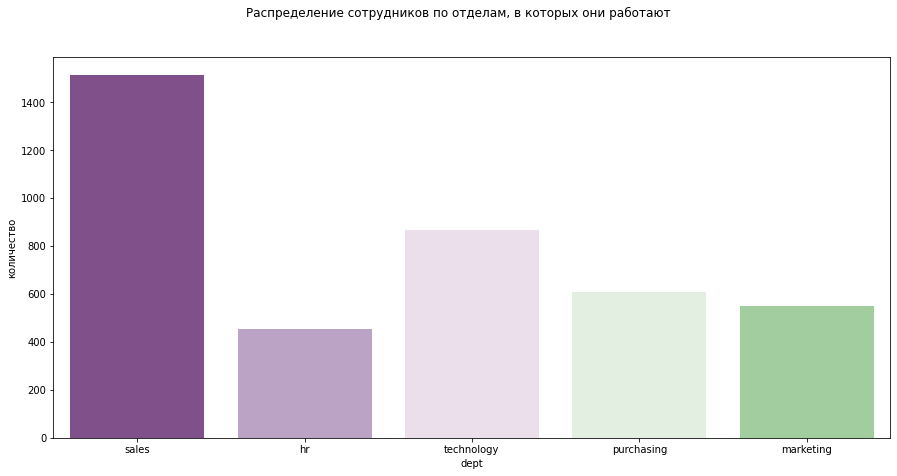

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64


In [16]:
viz_bar_character(df_train_job, 'dept', 'Распределение сотрудников по отделам, в которых они работают')

Для исследования представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1512), меньше всего в отделе HR (456).

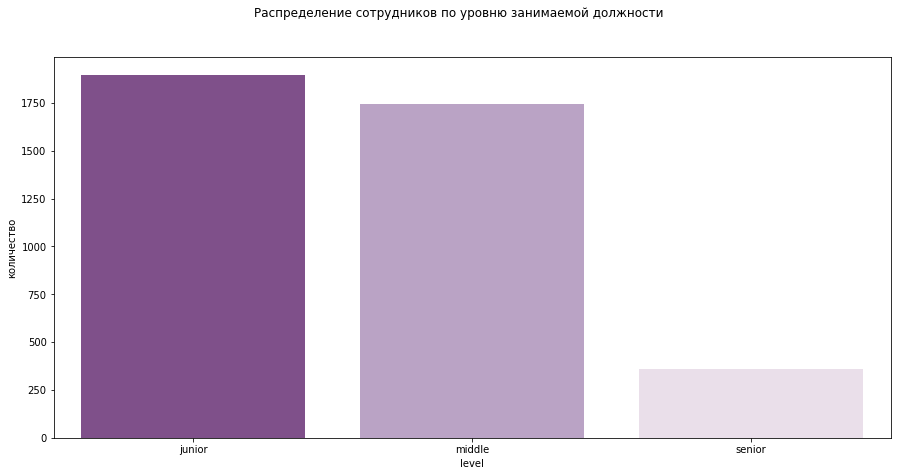

junior    1894
middle    1744
senior     358
Name: level, dtype: int64


In [17]:
viz_bar_character(df_train_job, 'level', 'Распределение сотрудников по уровню занимаемой должности')

В компании уровни занимаемой должности четко разграничены по иерархии: junior (1894 чел), middle (1744 чел), senior (358 чел).

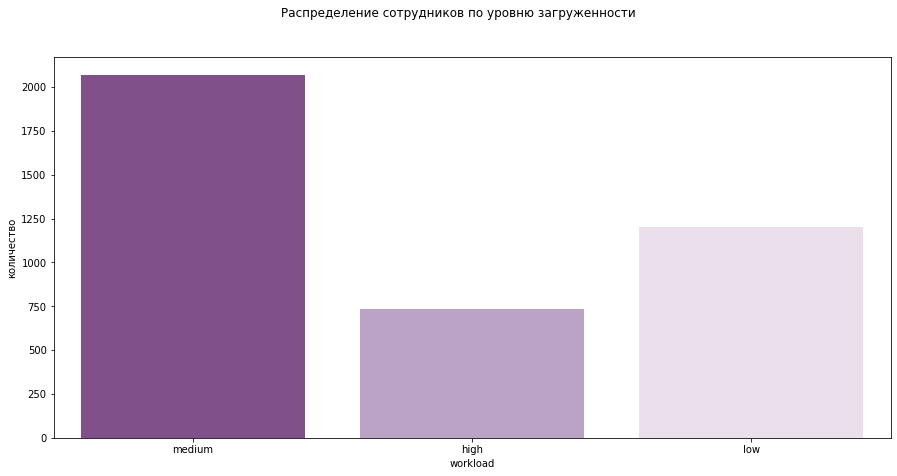

medium    2066
low       1200
high       734
Name: workload, dtype: int64


In [18]:
viz_bar_character(df_train_job, 'workload', 'Распределение сотрудников по уровню загруженности')

Что касается уровня загруженности сотрудников, то около половины из них (2066 чел) имеют среднюю степень, 734 человека с высоким уровнем загруженности и легче всего работается 1200 сотрудникам.

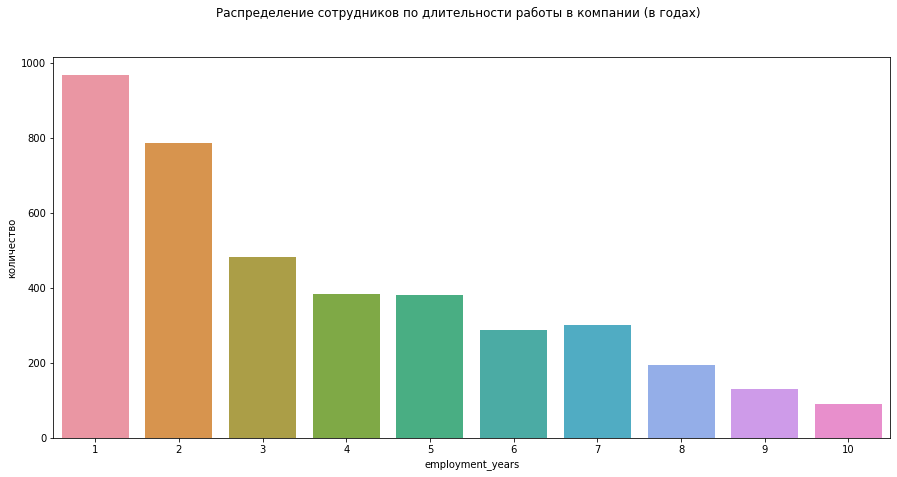

1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: employment_years, dtype: int64


In [19]:
viz_bar_character(df_train_job, 'employment_years', 'Распределение сотрудников по длительности работы в компании (в годах)')

Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 3 года.

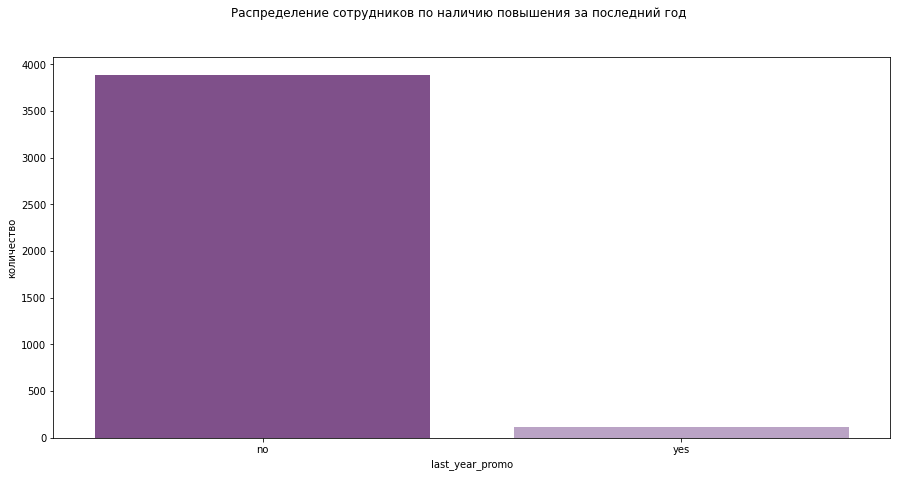

no     3880
yes     120
Name: last_year_promo, dtype: int64


In [20]:
viz_bar_character(df_train_job, 'last_year_promo', 'Распределение сотрудников по наличию повышения за последний год')

Из общего числа сотрудников только 120 человек имели повышение за последний год.

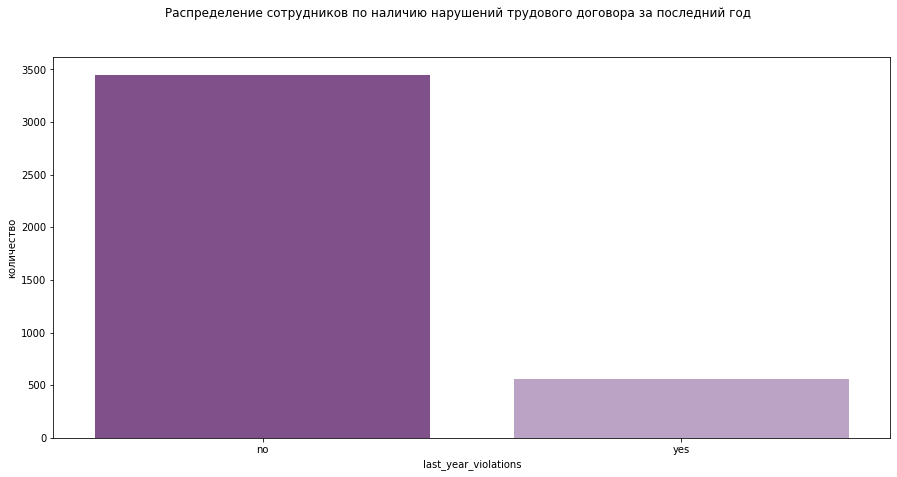

no     3441
yes     559
Name: last_year_violations, dtype: int64


In [21]:
viz_bar_character(df_train_job, 'last_year_violations', 'Распределение сотрудников по наличию нарушений трудового договора \
за последний год')

Около 14% сотрудников от общего числа имеют нарушения по трудовому договору за последний год. 

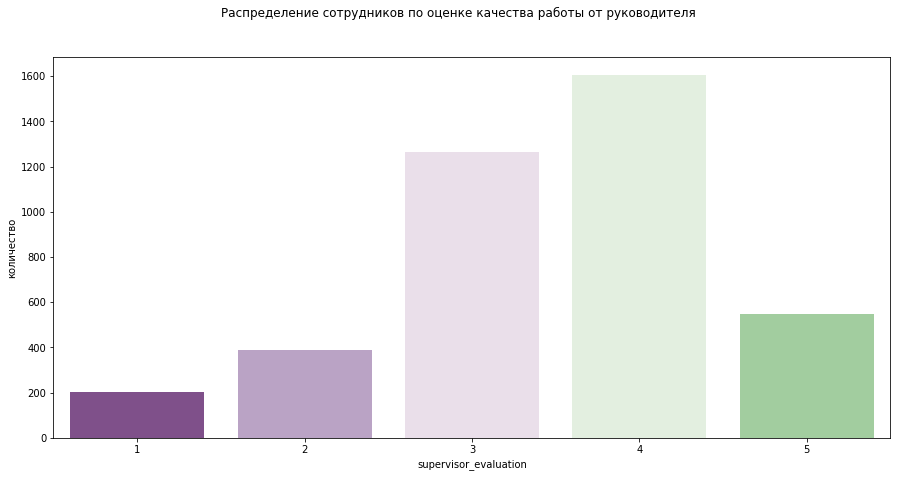

4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64


In [22]:
viz_bar_character(df_train_job, 'supervisor_evaluation', 'Распределение сотрудников по оценке качества работы от руководителя')

В компании руководитель оценивает сотрудников по качеству их работы. Исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 546 человек, а 201 человек имеют самый низкий балл (1). Рационально ли держать таких сотрудников в компании? Вопрос к компании.

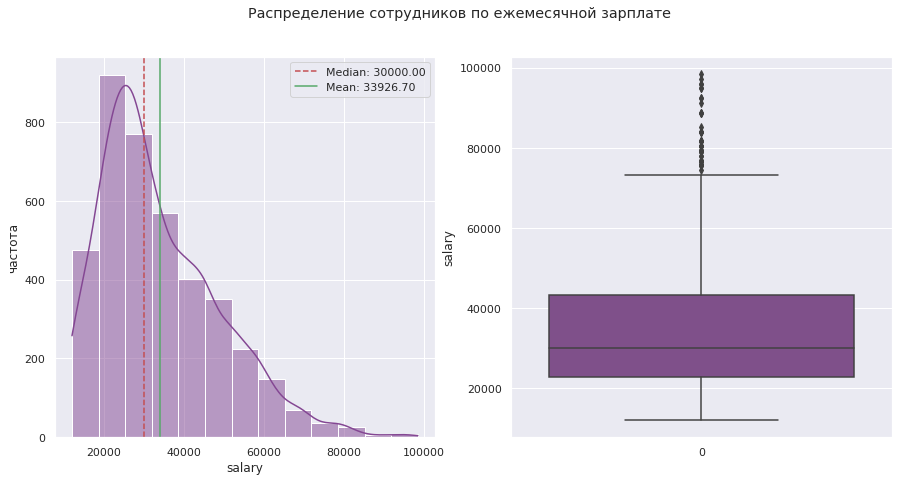

In [23]:
viz_num_character(df_train_job, 'salary', 'Распределение сотрудников по ежемесячной зарплате', 13)

Имеются выбросы по величине зарплаты. Рассмотрим этих сотрудников:

In [24]:
df_train_job.query('salary > 70000')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
32,176144,hr,senior,high,3,no,no,1,72000,0.22
45,538347,technology,senior,high,3,no,no,1,84000,0.21
141,128304,marketing,senior,high,7,no,no,3,80400,0.48
196,486576,marketing,senior,high,9,no,no,4,76800,0.66
198,763200,sales,senior,high,6,yes,no,4,72000,0.81
...,...,...,...,...,...,...,...,...,...,...
3839,868744,technology,senior,high,5,yes,no,4,97200,0.84
3894,459612,technology,senior,high,9,no,no,4,88800,0.79
3902,612590,technology,senior,high,8,no,no,3,76800,0.39
3942,215496,technology,senior,medium,10,no,yes,4,70800,0.63


Имеем 85 сотрудников с зарплатой от 70000. Посмотрим какой уровень должности у данных сотрудников:

In [25]:
salary_big = df_train_job.query('salary > 70000')
salary_big['level'].unique()

array(['senior'], dtype=object)

У всех сотрудников с зарплатой от 70000 занимаемая должность на уровне 'senior'. Не считаю, что это аномалии, т.к. специалисты такого уровня всегда высокооплачиваемы.

Минимальная зарплата в компании составляет 12000, максимальная - 98400. Среднее значение - 33926.7, медиана - 30000.0. 

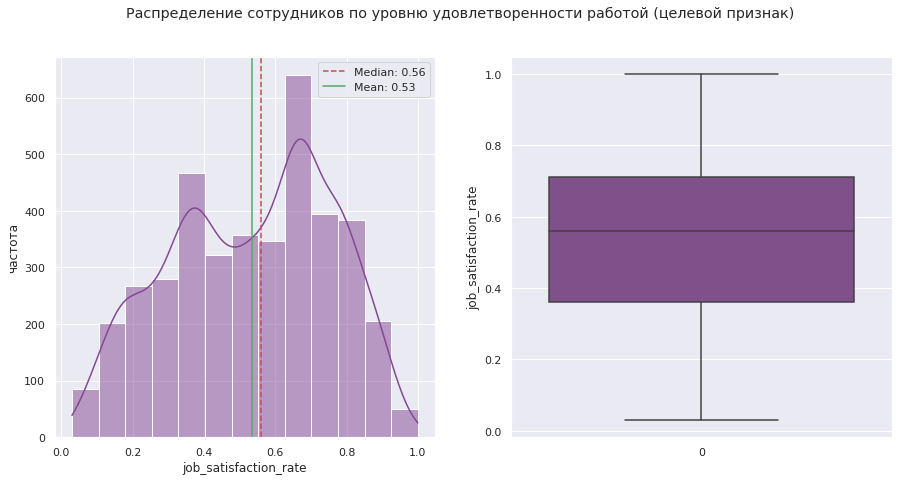

In [26]:
viz_num_character(df_train_job, 'job_satisfaction_rate', 'Распределение сотрудников по уровню удовлетворенности работой\
 (целевой признак)', 13)

Уровень удовлетворённости сотрудника работой в компании является целевым признаком. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. По итогу мы имеем средний уровень удовлетворенности 0.53, медианное значение - 0.56. Не очень высокие показатели, руководству есть над чем работать по созданию комфортности условий для труда, т.к чем выше уровень удовлетворенности, тем выше продуктивность сотрудников, что влечет за собой рост показателей самой компании.

##### Датафрейм df_test_features (входные признаки тестовой выборки)

**Проведем статистический анализ всех признаков**. 

Числовые характеристики:

In [27]:
df_test_features.drop('id', axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


**Вывод**: аномальных значений нет.

**Визуализируем признаки:**

Определим число "бинов" для данного датафрейма по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 2000 наблюдений, получаем bins = 12.

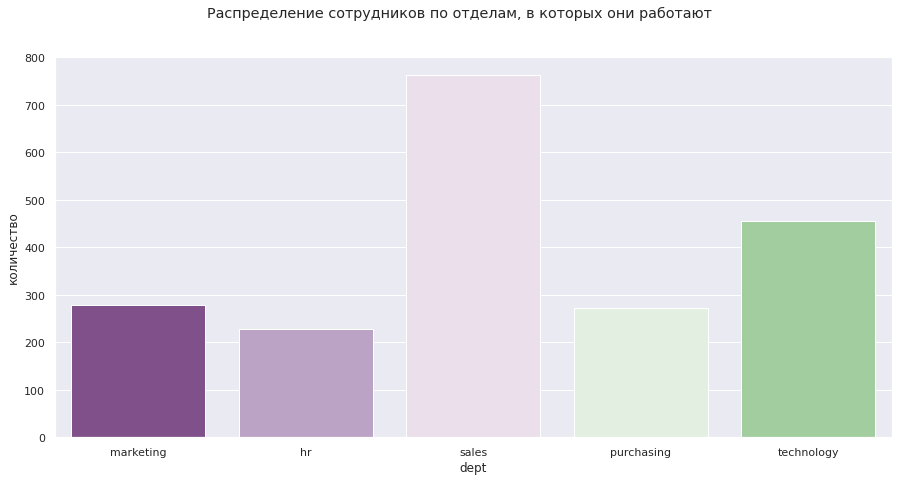

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64


In [28]:
viz_bar_character(df_test_features, 'dept', 'Распределение сотрудников по отделам, в которых они работают')

В тестовой выборке представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227).

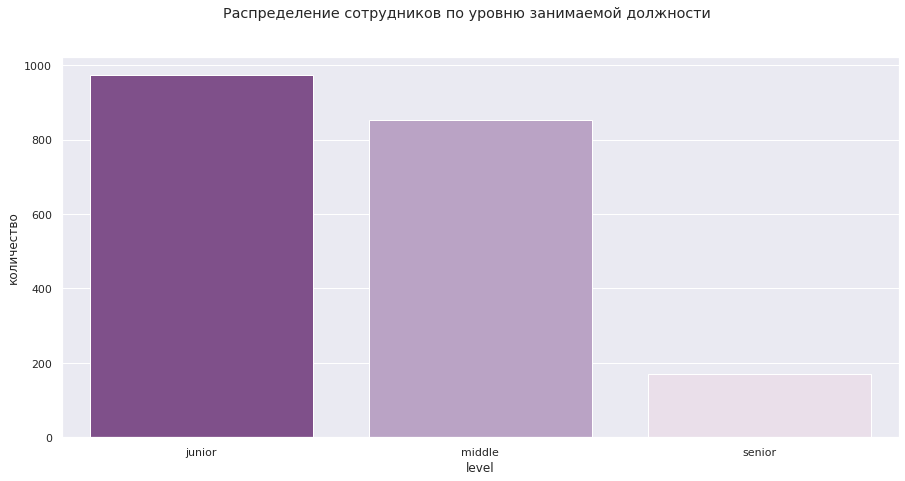

junior    974
middle    854
senior    171
Name: level, dtype: int64


In [29]:
viz_bar_character(df_test_features, 'level', 'Распределение сотрудников по уровню занимаемой должности')

По уровню занимаемой должности имеем: junior (974 чел), middle (854 чел), senior (171 чел).

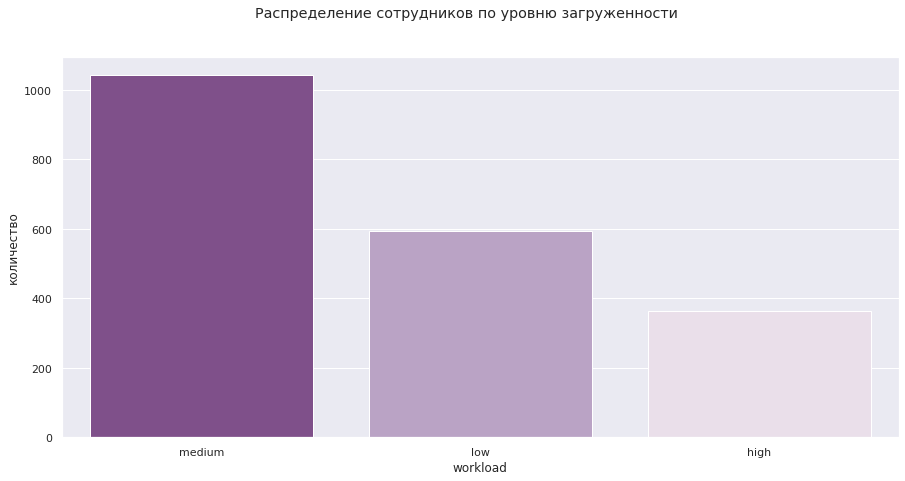

medium    1043
low        593
high       363
Name: workload, dtype: int64


In [30]:
viz_bar_character(df_test_features, 'workload', 'Распределение сотрудников по уровню загруженности')

Что касается уровня загруженности сотрудников, то около половины из них (1043 чел) имеют среднюю степень, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам.

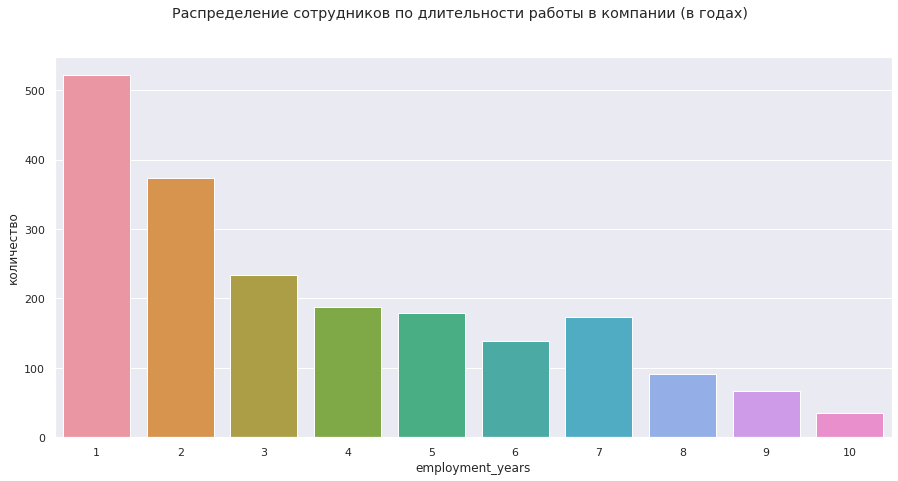

1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64


In [31]:
viz_bar_character(df_test_features, 'employment_years', 'Распределение сотрудников по длительности работы в компании (в годах)')

Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.66, медиана - 3 года.

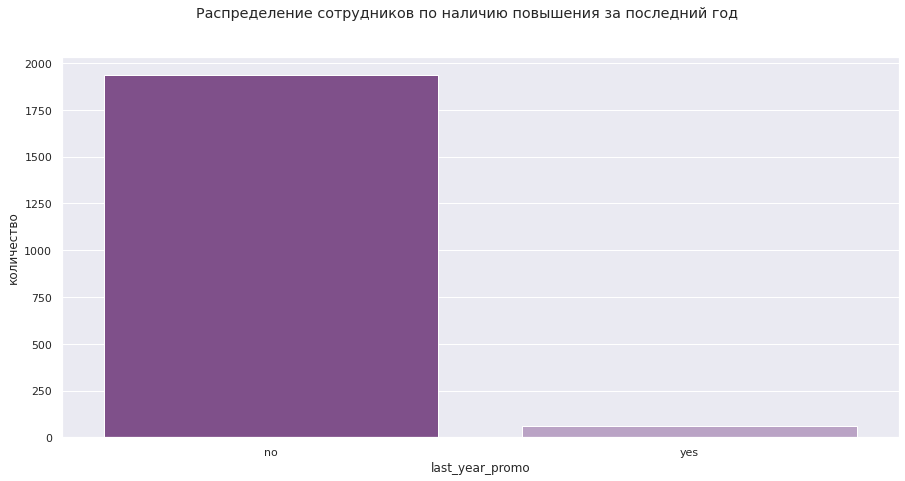

no     1937
yes      63
Name: last_year_promo, dtype: int64


In [32]:
viz_bar_character(df_test_features, 'last_year_promo', 'Распределение сотрудников по наличию повышения за последний год')

Из общего числа сотрудников тестовой выборки только 63 человека имели повышение за последний год.

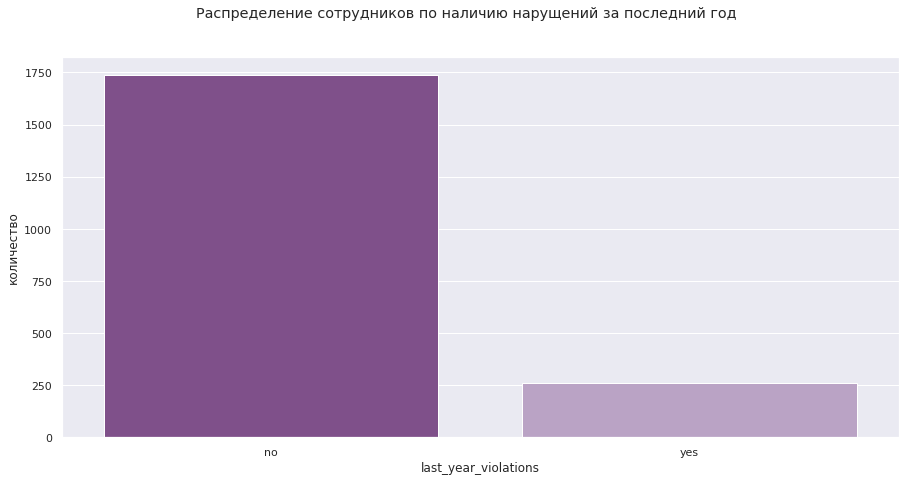

no     1738
yes     262
Name: last_year_violations, dtype: int64


In [33]:
viz_bar_character(df_test_features, 'last_year_violations', 'Распределение сотрудников по наличию нарущений за последний год')

262 сотрудника из 2000 в выборке имеют нарушения по трудовому договору за последний год.

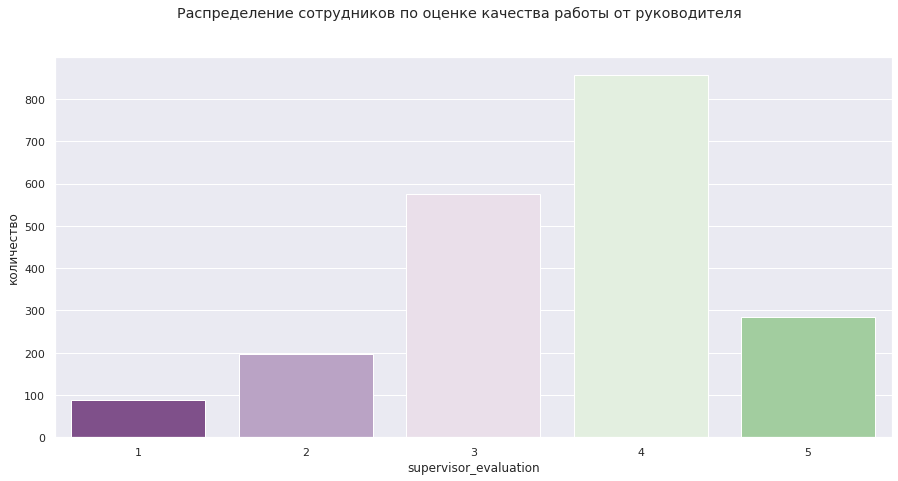

4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64


In [34]:
viz_bar_character(df_test_features, 'supervisor_evaluation', 'Распределение сотрудников по оценке качества работы от \
руководителя')

Исправно выполняющих свои должностные обязанности сотрудников по оценке руководителя (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1)

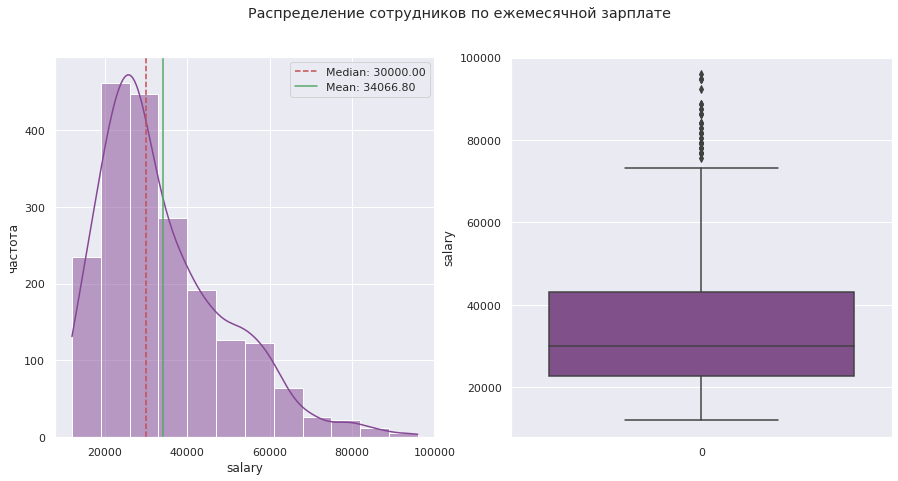

In [35]:
viz_num_character(df_test_features, 'salary', 'Распределение сотрудников по ежемесячной зарплате', 12)

Данные из тестовой выборки практически не отличаются по распределению от тренировочной выборки. В целом, компанией предоставлены данные хорошего качества.

##### Датафрейм df_test_target (целевой признак тестовой выборки)

**Проведем статистический анализ признака**. 

Числовые характеристики:

In [36]:
df_test_target.drop('id', axis=1).describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


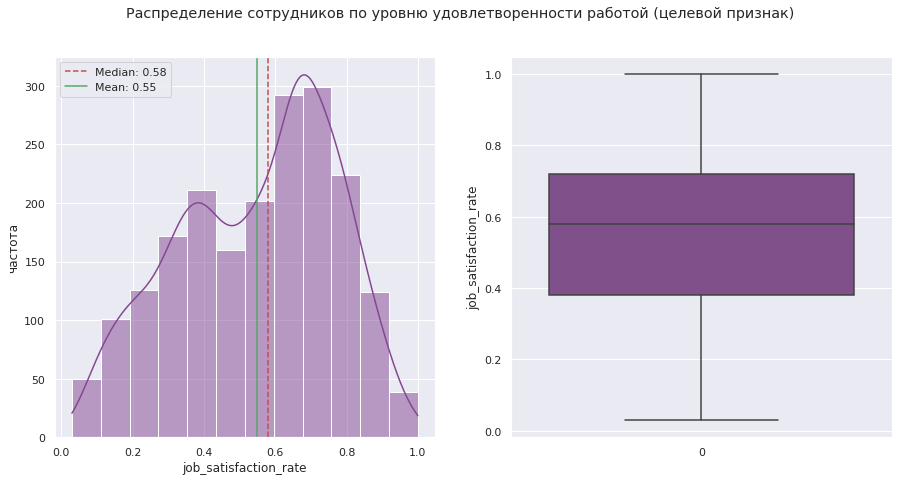

In [37]:
viz_num_character(df_test_target, 'job_satisfaction_rate', 'Распределение сотрудников по уровню удовлетворенности работой\
 (целевой признак)', 12)

Доля удовлетворенности сотрудников рассчитывается от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. По итогу в тестовой выборке целевого признака мы имеем средний уровень удовлетворенности 0.55, медианное значение - 0.58.

#### Вывод

Проведен исследовательский анализ данных, который дал представление о распределении признаков и их значениях:

- **Датафрейм df_train_job с тренировочной выборкой**:

   - Для исследования представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1512), меньше всего в отделе HR (456). 
   - В компании уровни занимаемой должности четко разграничены по иерархии: junior (1894 чел), middle (1744 чел), senior (358 чел). 
   - Что касается уровня загруженности сотрудников, то около половины из них (2066 чел) имеют среднюю степень, 734 человека с высоким уровнем загруженности и легче всего работается 1200 сотрудникам.
   - Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 3 года. 
   - Из общего числа сотрудников только 120 человек имели повышение за последний год. 
   - Около 14% сотрудников от общего числа имеют нарушения по трудовому договору за последний год. 
   - В компании руководитель оценивает сотрудников по качеству их работы. Исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 546 человек, а 201 человек имеют самый низкий балл (1). 
   - У всех сотрудников с зарплатой от 70000 занимаемая должность на уровне 'senior'. Не считаю, что это аномалии, т.к. специалисты такого уровня всегда высокооплачиваемы. Минимальная зарплата в компании составляет 12000, максимальная - 98400. Среднее значение - 33926.7, медиана - 30000.0.
   - Уровень удовлетворённости сотрудника работой в компании является целевым признаком. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. По итогу мы имеем средний уровень удовлетворенности 0.53, медианное значение - 0.56. Не очень высокие показатели, руководству есть над чем работать по созданию комфортности условий для труда, т.к чем выше уровень удовлетворенности, тем выше продуктивность сотрудников, что влечет за собой рост показателей самой компании.
   
- **Датафрейм df_test_features с тестовой выборкой**:
   - В тестовой выборке представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227).
   - По уровню занимаемой должности имеем: junior (974 чел), middle (854 чел), senior (171 чел).
   - Что касается уровня загруженности сотрудников, то около половины из них (1043 чел) имеют среднюю степень, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам.
   - Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.66, медиана - 3 года.
   - Из общего числа сотрудников тестовой выборки только 63 человека имели повышение за последний год.
   - 262 сотрудника из 2000 в выборке имеют нарушения по трудовому договору за последний год.
   - Исправно выполняющих свои должностные обязанности сотрудников по оценке руководителя (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1)

- **Датафрейм df_test_target с целевым признаком тестовой выборки**:
   - Средний уровень удовлетворенности 0.55, медианное значение - 0.58 при диапазоне значений от 0 до 1.

Аномальных значений нет, компанией предоставлены данные хорошего качества.

### Корреляционный анализ данных

#### Датафрейм df_train_job (тренировочная выборка)

Построим матрицу корреляции признаков датафрейма df_train_job и тепловую карту для ее визуализации:

In [38]:
# Вычисление матрицы корреляции с использованием phik
interval_cols = ['salary', 'job_satisfaction_rate']

corr_matrix = df_train_job.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
corr_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.016509,0.037853,0.000000,0.000000,0.105495,0.282265,0.082086
level,0.000000,1.000000,0.419114,0.682773,0.101613,0.000000,0.000000,0.717630,0.080620
workload,0.016509,0.419114,1.000000,0.181941,0.058663,0.000000,0.037023,0.788820,0.056128
employment_years,0.037853,0.682773,0.181941,1.000000,0.183579,0.056808,0.000000,0.483419,0.325603
last_year_promo,0.000000,0.101613,0.058663,0.183579,1.000000,0.000000,0.013681,0.215025,0.190803
last_year_violations,0.000000,0.000000,0.000000,0.056808,0.000000,1.000000,0.182042,0.010078,0.560348
supervisor_evaluation,0.105495,0.000000,0.037023,0.000000,0.013681,0.182042,1.000000,0.000000,0.764364
salary,0.282265,0.717630,0.788820,0.483419,0.215025,0.010078,0.000000,1.000000,0.165830
job_satisfaction_rate,0.082086,0.080620,0.056128,0.325603,0.190803,0.560348,0.764364,0.165830,1.000000


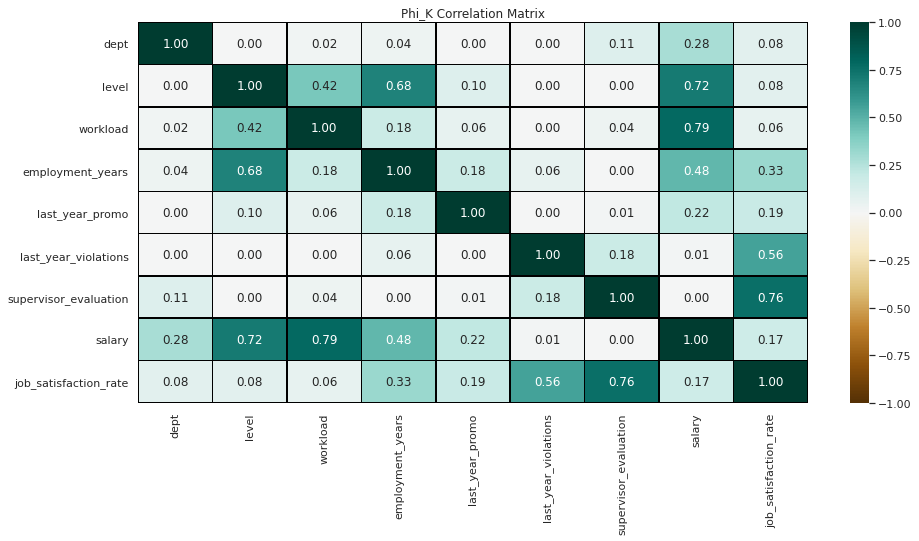

In [39]:
# визуализация - тепловая карта
sns.heatmap(corr_matrix, 
                annot=True, vmin=-1, vmax=1, center=0, cmap='BrBG', 
                linecolor='black', linewidths=0.5, fmt=".2f")
sns.set(rc={'figure.figsize': (15, 10)})
plt.title('Phi_K Correlation Matrix')
plt.show()

In [40]:
print('Шкала Чеддока - шкала силы корреляционной связи')
from IPython.display import Image
Image(url='https://intuit.ru/EDI/22_08_23_1/1692656410-28489/tutorial/25/objects/8/files/8_1.gif')

Шкала Чеддока - шкала силы корреляционной связи


**Вывод**:

**Целевой признак коррелирует с входными признаки и наблюдается связь:**
- высокая:
  - оценка руководителя за качество работы сотрудника (0.76);
- заметная:
  - нарушение трудового договора (0.56);
- умеренная;
  - длительность работы в компании (0.33);
- слабая:
  - повышение за последний год (0.19);
  - ежемесячная зарплата сотрудника (0.17).
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) не наблюдается.**

#### Датафрейм df_test_job (тестовая выборка)

Объединим датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id':

In [41]:
df_test_job = df_test_features.merge(df_test_target, on='id', how='left')
print('Размерность нового датафрейма df_test_job после объединения:', df_test_job.shape)
df_test_job.head()

Размерность нового датафрейма df_test_job после объединения: (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Построим матрицу корреляции признаков датафрейма df_test_job и тепловую карту для ее визуализации:

In [42]:
# Вычисление матрицы корреляции с использованием phik
interval_cols = ['salary', 'job_satisfaction_rate']

corr_matrix = df_test_job.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
corr_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406,0.075774
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998,0.095706
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849,0.052308
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903
job_satisfaction_rate,0.075774,0.095706,0.052308,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000


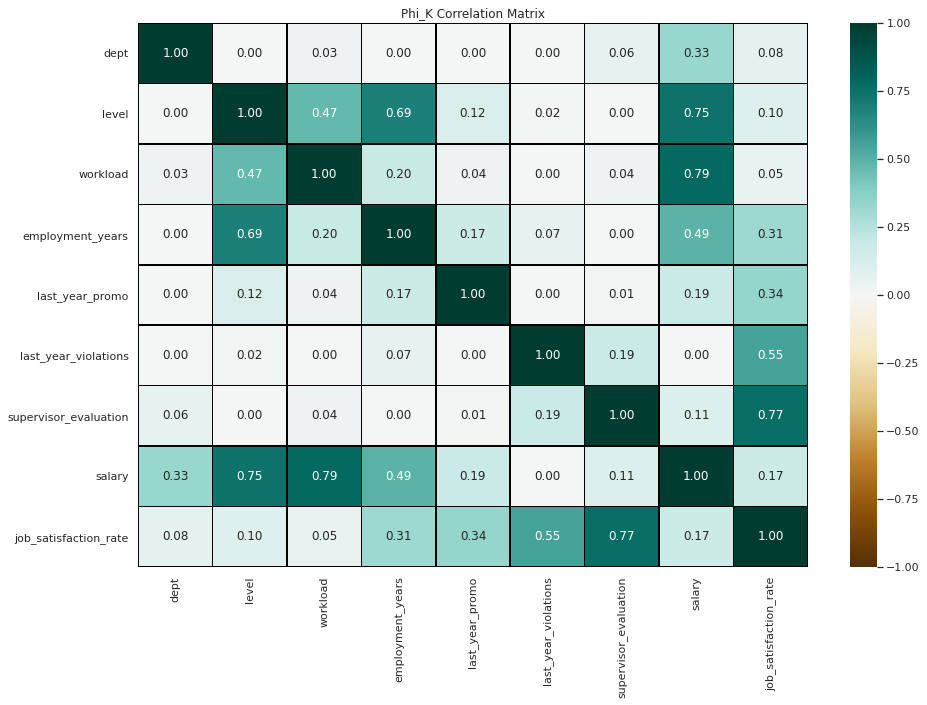

In [43]:
# визуализация - тепловая карта
sns.heatmap(corr_matrix, 
                annot=True, vmin=-1, vmax=1, center=0, cmap='BrBG', 
                linecolor='black', linewidths=0.5, fmt=".2f")
sns.set(rc={'figure.figsize': (15, 10)})
plt.title('Phi_K Correlation Matrix')
plt.show()

**Вывод**:

**Целевой признак коррелирует с входными признаки и наблюдается связь:**
- высокая:
  - оценка руководителя за качество работы сотрудника (0.77);
- заметная:
  - нарушение трудового договора (0.55);
- умеренная;
  - длительность работы в компании (0.31);
  - повышение за последний год (0.34);
- слабая:
  - уровень занимаемой должности (0.1);
  - ежемесячная зарплата сотрудника (0.17).
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) не наблюдается.**

В данных нет существенных различий между тренировочной и тестовой выборками в части распределений признаков - оценка модели, полученная на тестовой выборке, будет корректной.

### Подготовка данных

Удалим из датафрейма df_train_job столбец 'id', так как этот признак не предоставляет дополнительной информации для обучения модели, а лишь увеличивает вычислительные затраты и время обучения:

In [44]:
df_train_job = df_train_job.drop('id', axis=1)
df_train_job.sample(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3632,marketing,junior,medium,2,no,no,2,24000,0.35
3722,hr,senior,high,7,no,no,3,67200,0.30


Проверяем наличие явных дубликатов после удаления 'id':

In [45]:
df_train_job.duplicated().sum()

245

Удаляем дубликаты:

In [46]:
df_train_job = df_train_job.drop_duplicates().reset_index(drop=True)
print('Количество явных дубликатов:',df_train_job.duplicated().sum())
df_train_job.shape

Количество явных дубликатов: 0


(3755, 9)

Определяем выборки:

In [47]:
X_train = df_train_job.drop('job_satisfaction_rate', axis=1)
X_test = df_test_job.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = df_train_job['job_satisfaction_rate']
y_test = df_test_job['job_satisfaction_rate']

# проверяем разделение на выборки:
print(f'''
Размерность X_train: {X_train.shape}
Размерность X_test: {X_test.shape}
Размерность y_train: {y_train.shape}
Размерность y_test: {y_test.shape}
''')


Размерность X_train: (3755, 8)
Размерность X_test: (2000, 8)
Размерность y_train: (3755,)
Размерность y_test: (2000,)



Разделение прошло верно.

Создаем списки с названиями признаков:

In [48]:
# для OneHotEncoder 
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# для OrdinalEncoder
ord_columns = ['level', 'workload']

# для масштабирования 
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создаем пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder):

In [49]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

Создаем пайплайн ord_pipe, который включает в себя шаги: simpleImputer_ord (заполняет пропуски, если они есть, самым частым встречающимся значением) и ord (кодирование с помощью OrdinalEncoder):

In [50]:
# SimpleImputer + OrdinalEncoder
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
) 

ord_pipe

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['junior', 'middle', 'senior'],
                                            ['low', 'medium', 'high']],
                                handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

Создаем общий пайплайн подготовки данных data_preprocessor, который объединит пайплайны обработки категориальных признаков и масштабирование количественных признаков:

In [51]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], remainder='passthrough'
)

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'senior'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num', MinMaxScaler(),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary'])])

Cоздаем итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели линейной регрессии:

In [52]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression(n_jobs=-1))
])

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', LinearRegression(n_jobs=-1))])

**Вывод**: на этапе подготовки данных было выполнено:

- объединены датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id';
- из датафрейма df_train_job с тренировочной выборкой удален столбец 'id', так как этот признак не предоставляет дополнительной информации для обучения модели, а лишь увеличивает вычислительные затраты и время обучения;
- найдены явные дубликаты (245) в df_train_job после удаления 'id', удалены;
- определены выборки для моделирования, созданы списки с признаками для обработки. Кодирование признаков осуществлялось с помощью OneHotEncoder и OrdinalEncoder;
- создан пайплайн, включащий в себя этапы:
   - пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder);
   - пайплайн ord_pipe, который включает в себя шаги: simpleImputer_ord (заполняет пропуски, если они есть, самым частым встречающимся значением) и ord (кодирование с помощью OrdinalEncoder);
   - общий пайплайн подготовки данных data_preprocessor, который объединит пайплайны обработки категориальных признаков и масштабирование количественных признаков (MinMaxScaler);
   - итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели линейной регрессии.

### Обучение моделей

Выберем лучшую модель и проверим её качество на основе метрики SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Критерий успеха: SMAPE <= 15 на тестовой выборке.

In [53]:
# функция, возвращающая значение метрики SMAPE
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

# создадим scorer для SMAPE (greater_is_better=False указывает, что меньшие значения SMAPE лучше)
smape_scorer = make_scorer(smape, greater_is_better=False)

Подберем лучшие гиперпараметры и методы подготовки данных. Создадим список словарей для каждой модели в param_grid. Возьмем 2 модели: DecisionTreeRegressor и LinearRegression. В качестве метрики используем SMAPE (smape_scorer).

In [54]:
param_grid = [
   # словарь для модели DecisionTreeRegressor()
   {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models' : [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
] 

param_grid

[{'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': [None, 2, 3, 4, 5, 6],
  'models__max_features': range(2, 10),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LinearRegression(n_jobs=-1)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

Для поиска модели с гиперпараметрами используем поиск по сетке GridSearchCV:

In [55]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': [None, 2, 3, 4, 5, 6],
                          'models__max_features': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [56]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)
print()
print('Метрика SMAPE лучшей модели на кросс-валидации на обучающих данных:', grid_search.best_score_*-1)

Лучшая модель и её параметры:

 {'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': None, 'models__max_features': 6, 'preprocessor__num': 'passthrough'}

Метрика SMAPE лучшей модели на кросс-валидации на обучающих данных: 16.066435212733932


Сделаем предсказания на тестовой выборке и оценим качество модели по метрике:

In [57]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, y_pred),3)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.789


**Критерий успеха SMAPE <= 15 на тестовой выборке достигнут.**

**Проверка лучшей модели на адекватность**.

Для проверки модели на адекватность будем использовать классификатор DummyRegressor:

In [58]:
# Создаем экземпляр DummyRegressor
dummy_model = DummyRegressor()

# Обучаем DummyRegressor на тренировочных данных
dummy_model.fit(X_train, y_train)

# Предсказываем значения с помощью DummyRegressor на тестовых данных
dummy_model_pred = dummy_model.predict(X_test)

print(f'Метрика SMAPE dummy: {smape(y_test, dummy_model_pred).round(3)}')
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {smape(y_test, y_pred).round(3)}')

Метрика SMAPE dummy: 38.262
Метрика SMAPE лучшей модели на тестовой выборке: 14.789


Сравнение показывает, что выбранная лучшая модель значительно превосходит базовую, предложенную DummyRegressor, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи.

**Вывод**: на этапе обучения моделей было выполнено:

- создана функция, которая принимает на вход массивы NumPy и возвращает значение метрики SMAPE. Данная метрика была использована при подборе гиперпараметров и оценке качества моделей;
- обучены 2 модели: DecisionTreeRegressor и LinearRegression;
- сделан подбор гиперпараметров для моделей с помощью GridSearchCV;
- найдена **лучшая модель с лучшими гиперпараметрами: DecisionTreeRegressor(random_state=42), 'models__max_depth': None, 'models__max_features': 6 без масштабирования количественных признаков**, которая соответствует критерию успеха SMAPE <= 15 на тестовой выборке;
- выполнена проверка на адекватность лучшей модели, итог: выбранная лучшая модель значительно превосходит базовую, предложенную DummyRegressor, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи классификации.

### Общий вывод

**РЕАЛИЗАЦИЯ ЗАДАЧИ ПО ЭТАПАМ**:

1. **Загрузка данных и изучение информации**:

- В датафрейме df_train_job с тренировочными данными 4000 строк, 10 столбцов. Есть пропуски.
- В датафрейме df_test_features с входными признаками тестовой выборки 2000 строк, 9 столбцов. Есть пропуски.
- В датафрейме df_test_target с целевым признаком тестовой выборки 2000 строк, 2 столбца. Пропусков нет.

Названия столбцов записаны корректно, исправлений не требуется. Типы данных верные.

2. **Предобработка данных**:

- пробелы в значениях признаков заменены на пропуски NaN и будут обработаны со всеми остальными пропусками в пайплайне на этапе подготовки данных для моделирования;
- орфографическая ошибка исправлена с 'sinior' на 'senior';
- дубликатов не обнаружено;
- изменение типов данных не требуется.

3. **Исследовательский анализ данных**:

- **Датафрейм df_train_job с тренировочной выборкой**:

   - Для исследования представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1512), меньше всего в отделе HR (456). 
   - В компании уровни занимаемой должности четко разграничены по иерархии: junior (1894 чел), middle (1744 чел), senior (358 чел). 
   - Что касается уровня загруженности сотрудников, то около половины из них (2066 чел) имеют среднюю степень, 734 человека с высоким уровнем загруженности и легче всего работается 1200 сотрудникам.
   - Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 3 года. 
   - Из общего числа сотрудников только 120 человек имели повышение за последний год. 
   - Около 14% сотрудников от общего числа имеют нарушения по трудовому договору за последний год. 
   - В компании руководитель оценивает сотрудников по качеству их работы. Исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 546 человек, а 201 человек имеют самый низкий балл (1). 
   - У всех сотрудников с зарплатой от 70000 занимаемая должность на уровне 'senior'. Не считаю, что это аномалии, т.к. специалисты такого уровня всегда высокооплачиваемы. Минимальная зарплата в компании составляет 12000, максимальная - 98400. Среднее значение - 33926.7, медиана - 30000.0.
   - Уровень удовлетворённости сотрудника работой в компании является целевым признаком. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. По итогу мы имеем средний уровень удовлетворенности 0.53, медианное значение - 0.56. Не очень высокие показатели, руководству есть над чем работать по созданию комфортности условий для труда, т.к чем выше уровень удовлетворенности, тем выше продуктивность сотрудников, что влечет за собой рост показателей самой компании.
   
- **Датафрейм df_test_features с тестовой выборкой**:
   - В тестовой выборке представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227).
   - По уровню занимаемой должности имеем: junior (974 чел), middle (854 чел), senior (171 чел).
   - Что касается уровня загруженности сотрудников, то около половины из них (1043 чел) имеют среднюю степень, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам.
   - Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.66, медиана - 3 года.
   - Из общего числа сотрудников тестовой выборки только 63 человека имели повышение за последний год.
   - 262 сотрудника из 2000 в выборке имеют нарушения по трудовому договору за последний год.
   - Исправно выполняющих свои должностные обязанности сотрудников по оценке руководителя (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1)

- **Датафрейм df_test_target с целевым признаком тестовой выборки**:
   - Средний уровень удовлетворенности 0.55, медианное значение - 0.58 при диапазоне значений от 0 до 1.

Аномальных значений нет, компанией предоставлены данные хорошего качества.

4. **Корреляционный анализ данных**:

- **Датафрейм df_train_job с тренировочной выборкой**:

  Целевой признак коррелирует с входными признаки и наблюдается связь:
   - высокая:
     - оценка руководителя за качество работы сотрудника (0.76);
   - заметная:
     - нарушение трудового договора (0.56);
   - умеренная;
     - длительность работы в компании (0.33);
   - слабая:
     - повышение за последний год (0.19);
     - ежемесячная зарплата сотрудника (0.17).
     
     
- **Датафрейм df_test_job с тестовой выборкой**:

  Добавлен целевой признак в выборку для анализа. Целевой признак коррелирует с входными признаки и наблюдается связь:
    - высокая:
      - оценка руководителя за качество работы сотрудника (0.77);
    - заметная:
     - нарушение трудового договора (0.55);
    - умеренная;
     - длительность работы в компании (0.31);
     - повышение за последний год (0.34);
    - слабая:
     - уровень занимаемой должности (0.1);
     - ежемесячная зарплата сотрудника (0.17).
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) не наблюдается.**

В данных нет существенных различий между тренировочной и тестовой выборками в части распределений признаков - оценка модели, полученная на тестовой выборке, будет корректной.

5. **Подготовка данных**:

- объединены датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id';
- из датафрейма df_train_job с тренировочной выборкой удален столбец 'id', так как этот признак не предоставляет дополнительной информации для обучения модели, а лишь увеличивает вычислительные затраты и время обучения;
- найдены явные дубликаты (245) в df_train_job после удаления 'id', удалены;
- определены выборки для моделирования, созданы списки с признаками для обработки. Кодирование признаков осуществлялось с помощью OneHotEncoder и OrdinalEncoder;
- создан пайплайн, включащий в себя этапы:
   - пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder);
   - пайплайн ord_pipe, который включает в себя шаги: simpleImputer_ord (заполняет пропуски, если они есть, самым частым встречающимся значением) и ord (кодирование с помощью OrdinalEncoder);
   - общий пайплайн подготовки данных data_preprocessor, который объединит пайплайны обработки категориальных признаков и масштабирование количественных признаков (MinMaxScaler);
   - итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели линейной регрессии.
   
6. **Обучение моделей**:

- создана функция, которая принимает на вход массивы NumPy и возвращает значение метрики SMAPE. Данная метрика была использована при подборе гиперпараметров и оценке качества моделей;
- обучены 2 модели: DecisionTreeRegressor и LinearRegression;
- сделан подбор гиперпараметров для моделей с помощью GridSearchCV;
- найдена **лучшая модель с лучшими гиперпараметрами: DecisionTreeRegressor(random_state=42), 'models__max_depth': None, 'models__max_features': 6 без масштабирования количественных признаков**, которая соответствует критерию успеха SMAPE <= 15 на тестовой выборке;
- выполнена проверка на адекватность лучшей модели, итог: выбранная лучшая модель значительно превосходит базовую, предложенную DummyRegressor, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи классификации.

Метрика SMAPE лучшей модели на кросс-валидации на обучающих данных: 16.066.

Метрика SMAPE лучшей модели на тестовой выборке: 14.789

## ЗАДАЧА 2. Увольнение сотрудника из компании

Необходимо построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Загрузка данных, изучение информации

Загружаем данные и сохраняем в датареймы:

In [59]:
#Датафрейм с тренировочными данными
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

#Датафрейм с целевым признаком тестовой выборки
df_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

Датафрейм с входными признаками тестовой выборки вместе с job_satisfaction_rate оставляем из 1 задачи - df_test_job. 

In [60]:
print('Датафрейм df_train_quit с тренировочными данными:')
display(df_train_quit.sample(5))
df_train_quit.info()

Датафрейм df_train_quit с тренировочными данными:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3173,337891,marketing,junior,low,2,no,no,3,13200,yes
1386,133683,purchasing,junior,medium,1,no,no,3,21600,yes
174,412253,sales,middle,medium,10,no,no,5,38400,no
1702,912910,technology,junior,medium,3,no,no,3,26400,yes
3266,248912,marketing,junior,medium,1,no,no,5,31200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [61]:
print('Датафрейм df_test_job с входными признаками тестовой выборки:')
display(df_test_job.sample(5))
df_test_job.info()

Датафрейм df_test_job с входными признаками тестовой выборки:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1815,406100,sales,junior,medium,2,no,no,5,25200,0.82
1940,609299,sales,middle,low,6,no,no,4,28800,0.84
1856,488314,hr,junior,low,3,no,no,4,13200,0.64
1571,475905,sales,junior,low,1,no,no,5,19200,0.73
1264,693035,sales,junior,low,1,no,no,5,18000,0.71


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


In [62]:
print('Датафрейм df_test_target_quit с целевым признаком тестовой выборки:')
display(df_test_target_quit.sample(5))
df_test_target_quit.info()

Датафрейм df_test_target_quit с целевым признаком тестовой выборки:


,id,quit
549,696174,no
312,306753,no
593,963167,yes
1407,907491,no
249,145965,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Описание данных**:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании;
- quit - увольнение сотрудника из компании (целевой признак).

**Вывод**: 
- В датафрейме df_train_quit с тренировочными данными 4000 строк, 10 столбцов. Пропусков нет.
- В датафрейме df_test_job с входными признаками тестовой выборки 2000 строк, 10 столбцов. Есть пропуски (датафрейм из задачи 1).
- В датафрейме df_train_quit с целевым признаком тестовой выборки 2000 строк, 2 столбца. Пропусков нет.

Названия столбцов записаны корректно, исправлений не требуется. Типы данных верные.

###  Предобработка данных

Этап предобработки данных будем проводить для тренировочных данных в датафрейме df_train_quit. Датафрейм df_test_target_quit содержит бинарный целевой признак, пропусков нет, предобработка не требуется. Датафрейм df_test_job с тестовой выборкой входных признаков прошел этап предобработки в задаче 1, в нем имеются пропуски, которые будут обработаны в пайплайне.

#### Проверка наличия явных дубликатов

In [63]:
print(f'Количество явных дубликатов: {df_train_quit.duplicated().sum()}')

Количество явных дубликатов: 0


**Вывод**: дубликатов не обнаружено.

#### Проверка наличия неявных дубликатов, ошибок

Выводим уникальные значения для проверки наличия неявных дубликатов, ошибок. Выведем так же уникальные значения из тестовых входных признаков, чтобы сравнить соответствие написания значений:

In [64]:
dfs=[df_train_quit, df_test_job]

# список столбцов с категориальными значениями
columns=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# с помощью цикла выводим уникальные значения в выбранных столбцах
for df in dfs:
    print(f'Уникальные значения: ')
    for column in columns:
        print(df[column].unique())
        
print(df_train_quit['quit'].unique())

Уникальные значения: 
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
Уникальные значения: 
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'senior' nan]
['medium' 'low' 'high' nan]
['no' 'yes']
['no' 'yes']
['no' 'yes']


В столбце 'level' в df_train_quit обнаружена ошибка в записи. Заменяем значение 'sinior' на 'senior':

In [65]:
df_train_quit['level'] = df_train_quit['level'].str.replace('sinior', 'senior')

# Проверяем замену
display(df_train_quit['level'].unique())
print('Замена прошла успешно')

array(['middle', 'junior', 'senior'], dtype=object)

Замена прошла успешно


Проверим наличие явных дубликатов после преобразований:

In [66]:
print(f'Количество явных дубликатов: {df_train_quit.duplicated().sum()}')

Количество явных дубликатов: 0


**Вывод:** обнаружены ошибки в значениях:
- орфографическая ошибка исправлена с 'sinior' на 'senior'.

Неявных дубликатов нет. Изменение типов данных не требуется.

#### Вывод

На этапе предобработки данных было выполнено:

- орфографическая ошибка исправлена с 'sinior' на 'senior';
- изменение типов данных не требуется;
- явных дубликатов не обнаружено.

### Исследовательский анализ данных

#### Визуализация признаков

##### Датафрейм df_train_quit (тренировочная выборка)

**Проведем статистический анализ всех признаков**. 

Числовые характеристики:

In [68]:
df_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


**Вывод**: аномальных значений нет.

**Визуализируем признаки:**

Определим число "бинов" для данного датафрейма по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 4000 наблюдений, получаем bins = 13.

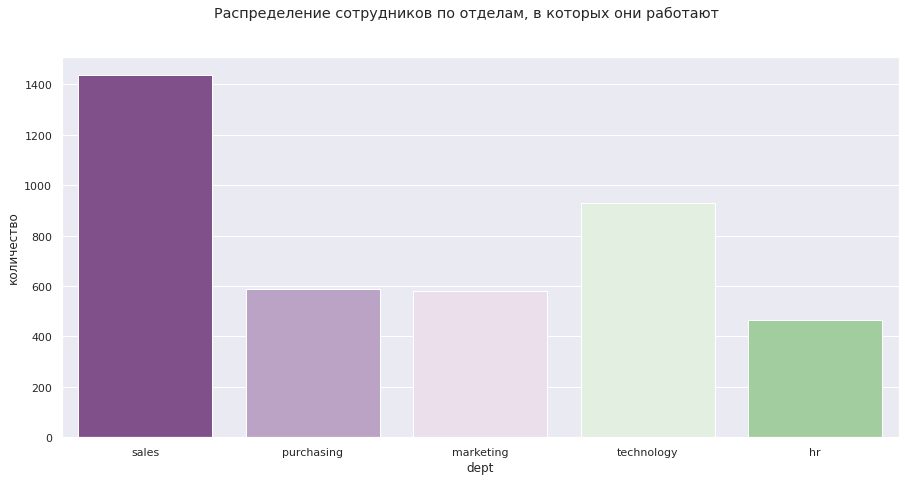

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64


In [69]:
viz_bar_character(df_train_quit, 'dept', 'Распределение сотрудников по отделам, в которых они работают')

Для исследования представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1438), меньше всего в отделе HR (464).

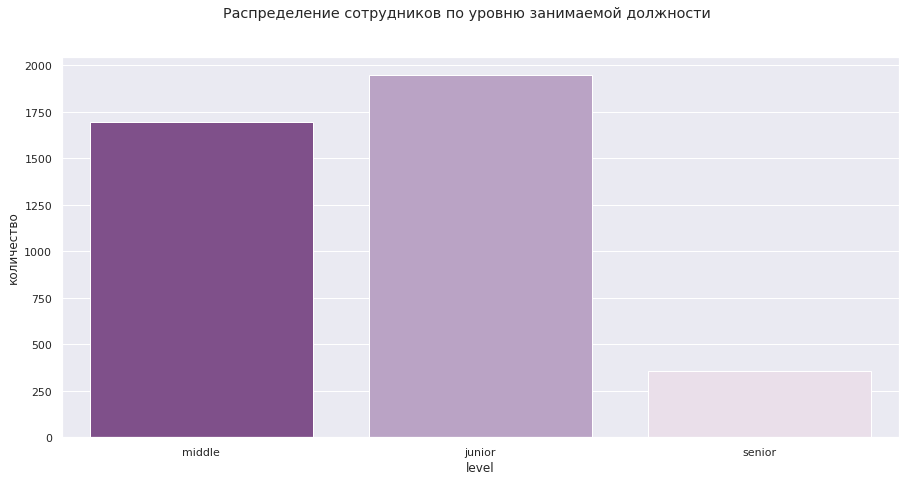

junior    1949
middle    1694
senior     357
Name: level, dtype: int64


In [70]:
viz_bar_character(df_train_quit, 'level', 'Распределение сотрудников по уровню занимаемой должности')

В компании уровни занимаемой должности четко разграничены по иерархии: junior (1949 чел), middle (1694 чел), senior (357 чел).

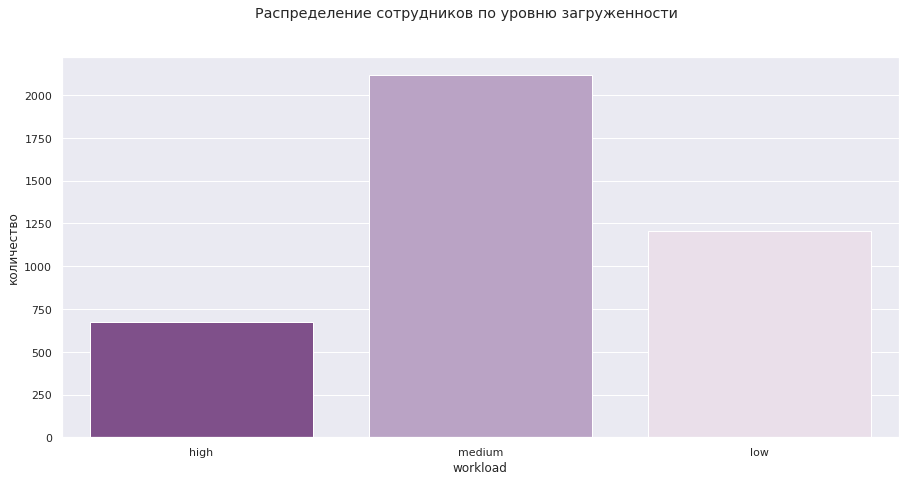

medium    2118
low       1208
high       674
Name: workload, dtype: int64


In [71]:
viz_bar_character(df_train_quit, 'workload', 'Распределение сотрудников по уровню загруженности')

Что касается уровня загруженности сотрудников, то почти половина из них (2118 чел) имеют среднюю степень, 674 человека с высоким уровнем загруженности и легче всего работается 1208 сотрудникам.

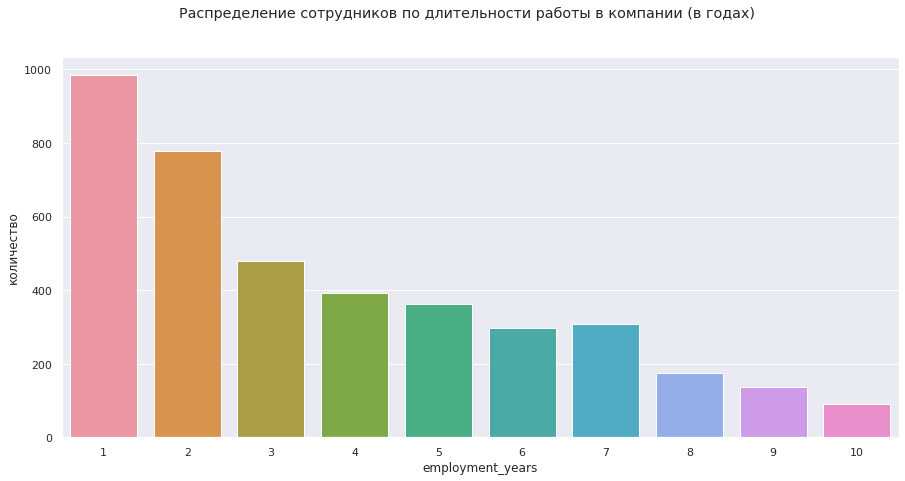

1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: employment_years, dtype: int64


In [72]:
viz_bar_character(df_train_quit, 'employment_years', 'Распределение сотрудников по длительности работы в компании (в годах)')

Из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 3 года.

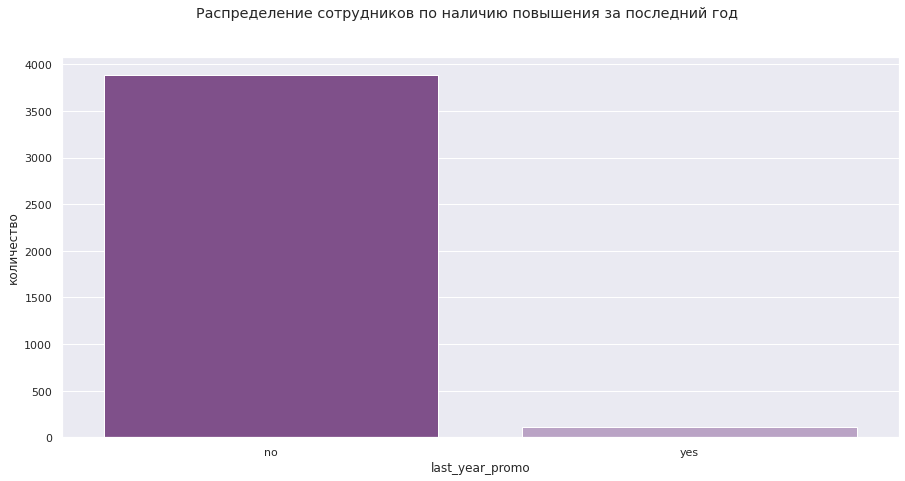

no     3887
yes     113
Name: last_year_promo, dtype: int64


In [73]:
viz_bar_character(df_train_quit, 'last_year_promo', 'Распределение сотрудников по наличию повышения за последний год')

Из общего числа сотрудников только 113 человек имели повышение за последний год.

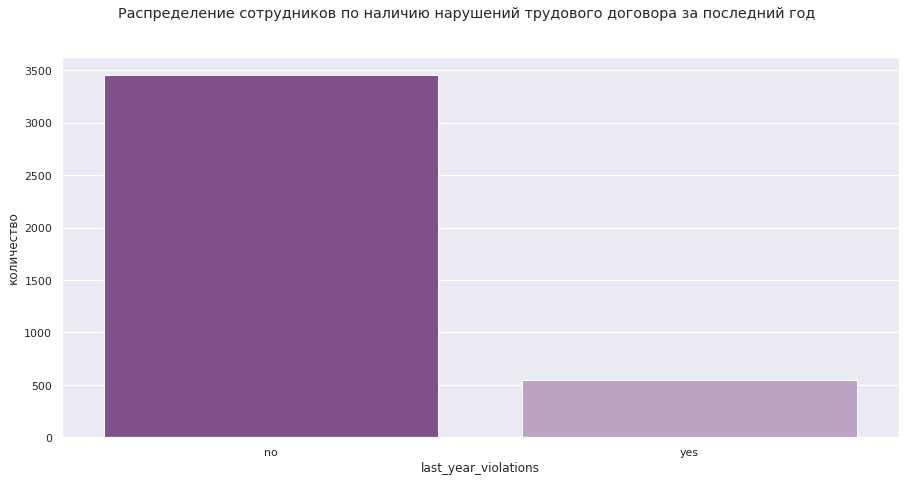

no     3455
yes     545
Name: last_year_violations, dtype: int64


In [74]:
viz_bar_character(df_train_quit, 'last_year_violations', 'Распределение сотрудников по наличию нарушений трудового договора \
за последний год')

Только 545 сотрудников имеют нарушения по трудовому договору за последний год.

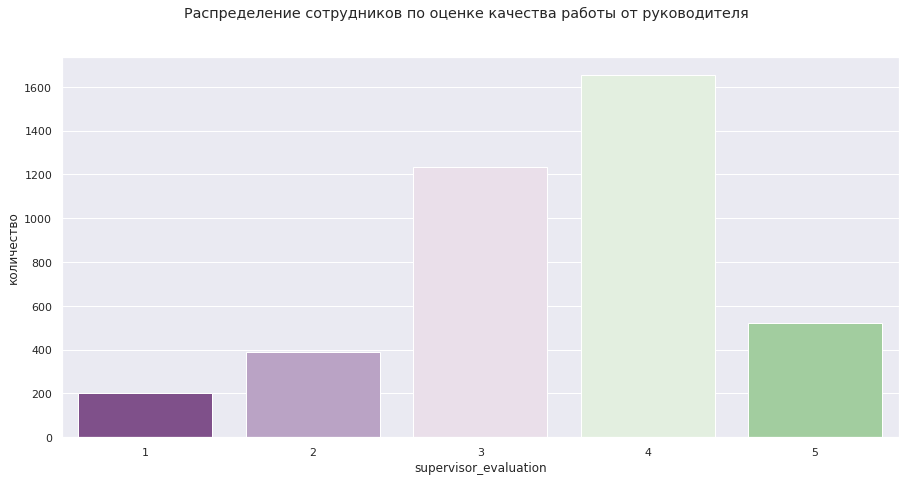

4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64


In [75]:
viz_bar_character(df_train_quit, 'supervisor_evaluation', 'Распределение сотрудников по оценке качества работы от руководителя')

В компании руководитель оценивает сотрудников по качеству их работы. Исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 520 человек, а 202 человек имеют самый низкий балл (1).

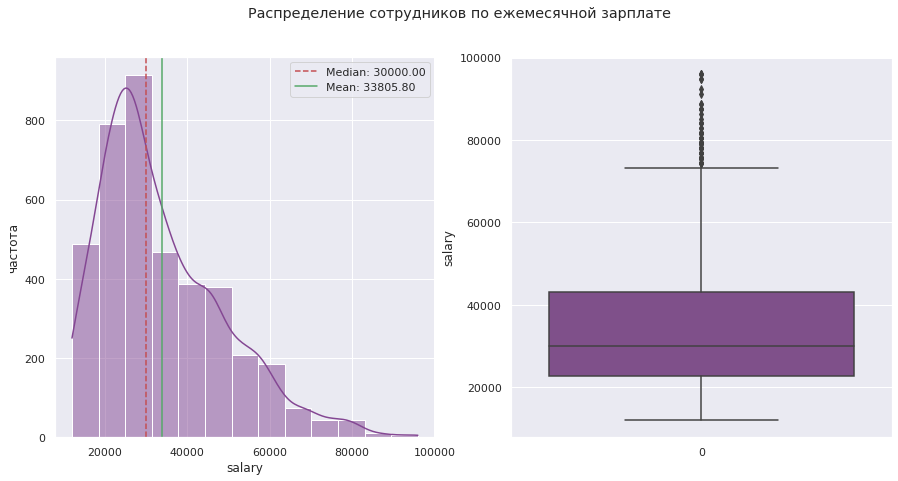

In [76]:
viz_num_character(df_train_quit, 'salary', 'Распределение сотрудников по ежемесячной зарплате', 13)

Имеются выбросы, но не считаю их аномальными значениями, т.к. специалисты высокого уровня и занимаемой должности высокооплачиваемы. Минимальная зарплата в компании составляет 12000, максимальная - 96000. Среднее значение - 33805.8, медиана - 30000.0.

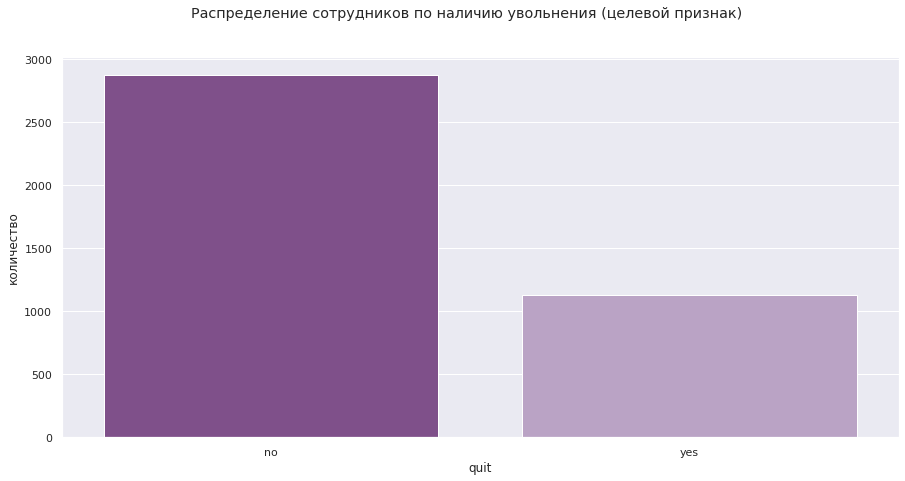

no     2872
yes    1128
Name: quit, dtype: int64


In [77]:
viz_bar_character(df_train_quit, 'quit', 'Распределение сотрудников по наличию увольнения (целевой признак)')

Имеем данные, в которых информация об уволившихся сотрудниках (1128) и действующих (2872). Имеем дисбаланс целевого признака, нужно это учесть при моделировании.

##### Датафрейм df_test_job (входные признаки тестовой выборки)

**Проведем статистический анализ всех признаков**. 

Числовые характеристики:

In [78]:
df_test_job.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,552765.213500,3.666500,3.526500,34066.800000,0.54878
std,253851.326129,2.537222,0.996892,15398.436729,0.22011
min,100298.000000,1.000000,1.000000,12000.000000,0.03000
25%,339052.000000,1.000000,3.000000,22800.000000,0.38000
50%,550793.000000,3.000000,4.000000,30000.000000,0.58000
75%,765763.750000,6.000000,4.000000,43200.000000,0.72000
max,999029.000000,10.000000,5.000000,96000.000000,1.00000


**Вывод**: аномальных значений нет.

**Визуализируем признаки:**

Определим число "бинов" для данного датафрейма по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 2000 наблюдений, получаем bins = 12.

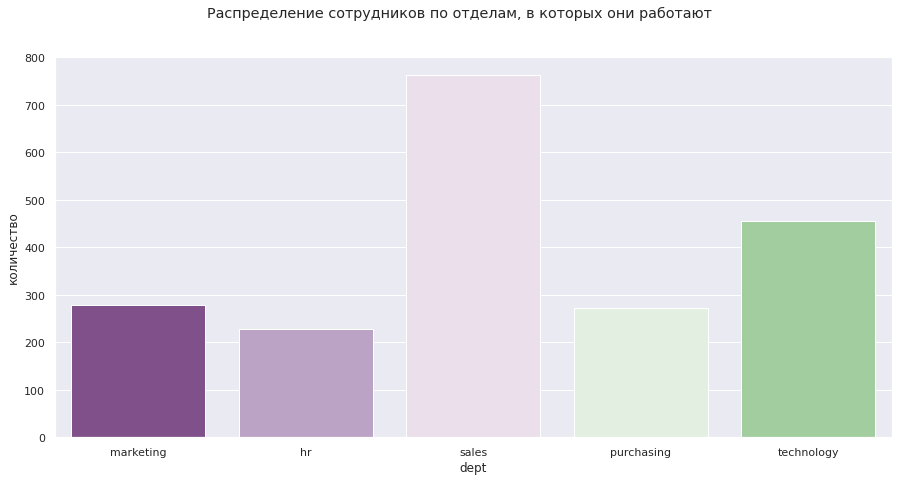

sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64


In [79]:
viz_bar_character(df_test_job, 'dept', 'Распределение сотрудников по отделам, в которых они работают')

В тестовой выборке представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227).

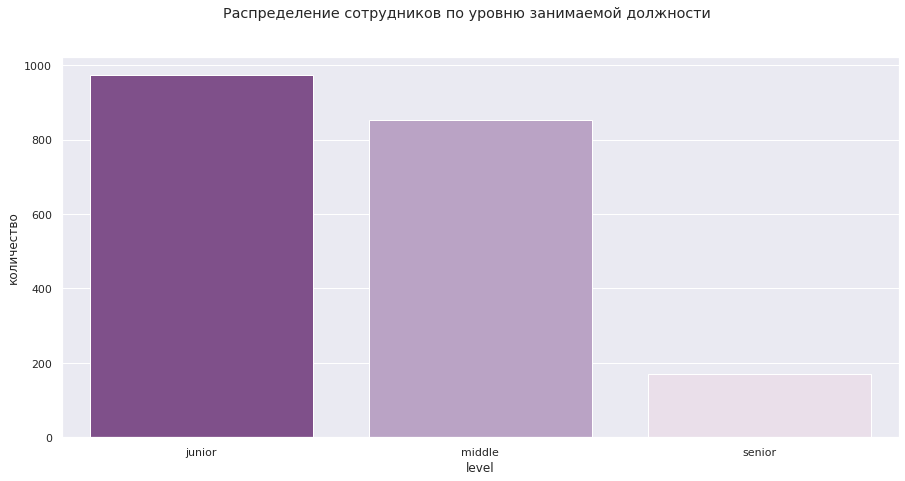

junior    974
middle    854
senior    171
Name: level, dtype: int64


In [80]:
viz_bar_character(df_test_job, 'level', 'Распределение сотрудников по уровню занимаемой должности')

По уровню занимаемой должности: junior (974 чел), middle (854 чел), senior (171 чел).

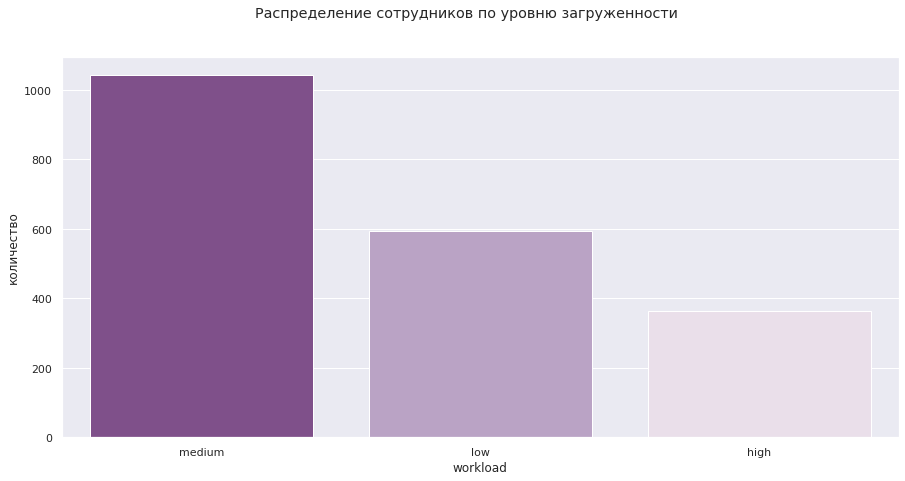

medium    1043
low        593
high       363
Name: workload, dtype: int64


In [81]:
viz_bar_character(df_test_job, 'workload', 'Распределение сотрудников по уровню загруженности')

Что касается уровня загруженности сотрудников, то чуть больше половины из них (1043 чел) имеют среднюю степень, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам.

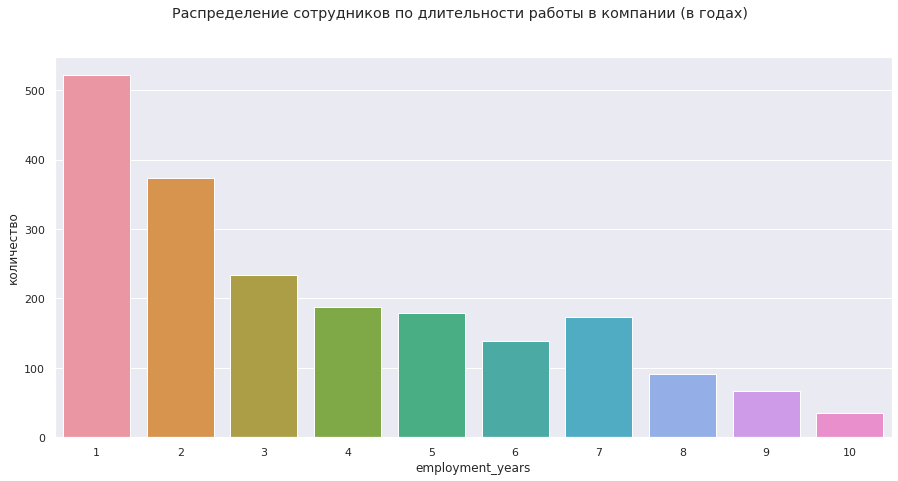

1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64


In [82]:
viz_bar_character(df_test_job, 'employment_years', 'Распределение сотрудников по длительности работы в компании (в годах)')

Из представленных данных тестовой выбооки, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.67, медиана - 3 года.

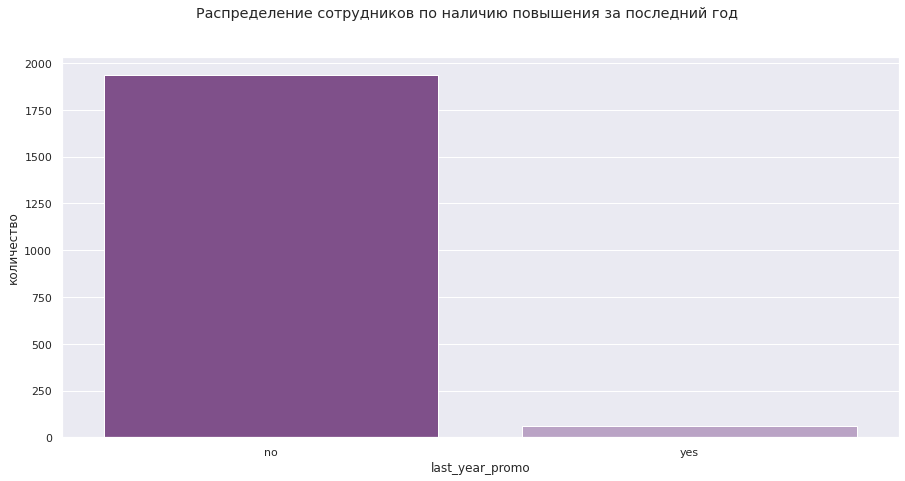

no     1937
yes      63
Name: last_year_promo, dtype: int64


In [83]:
viz_bar_character(df_test_job, 'last_year_promo', 'Распределение сотрудников по наличию повышения за последний год')

Из общего числа представленных сотрудников, только 63 человека имели повышение за последний год.

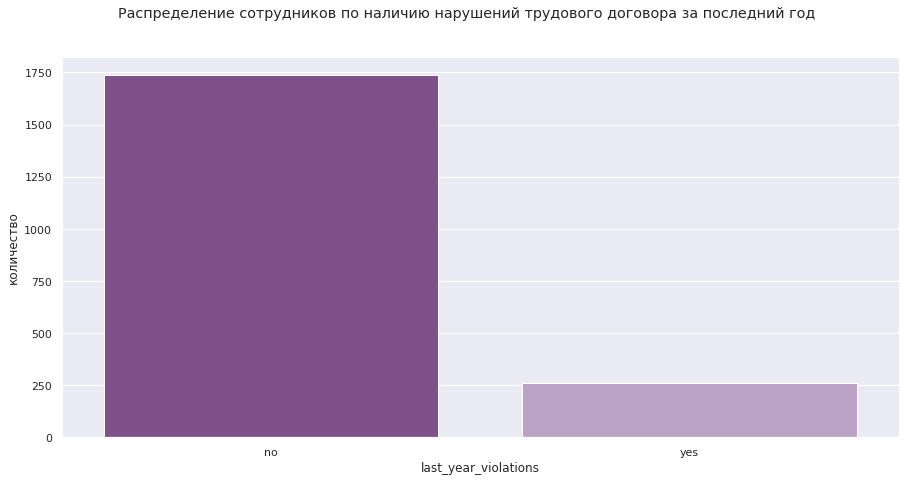

no     1738
yes     262
Name: last_year_violations, dtype: int64


In [84]:
viz_bar_character(df_test_job, 'last_year_violations', 'Распределение сотрудников по наличию нарушений трудового договора \
за последний год')

Только 262 сотрудника имеют нарушения по трудовому договору за последний год.

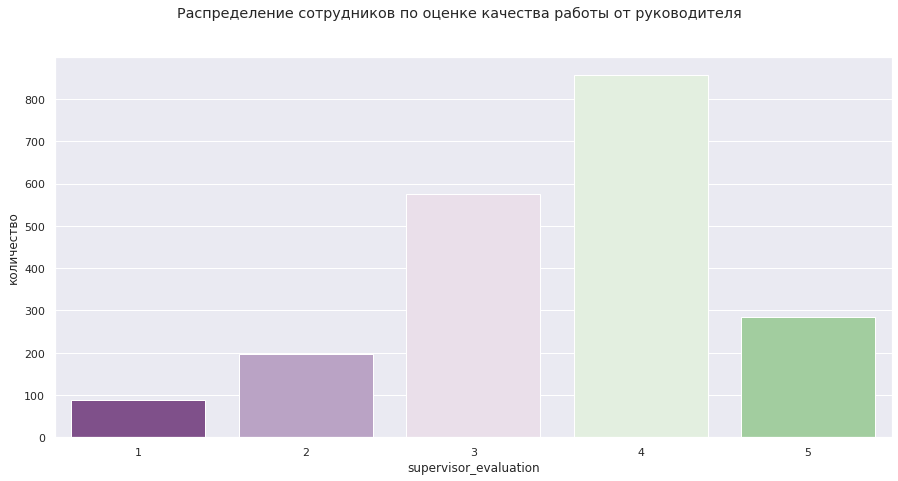

4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64


In [85]:
viz_bar_character(df_test_job, 'supervisor_evaluation', 'Распределение сотрудников по оценке качества работы от руководителя')

В компании руководитель оценивает сотрудников по качеству их работы. Исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1).

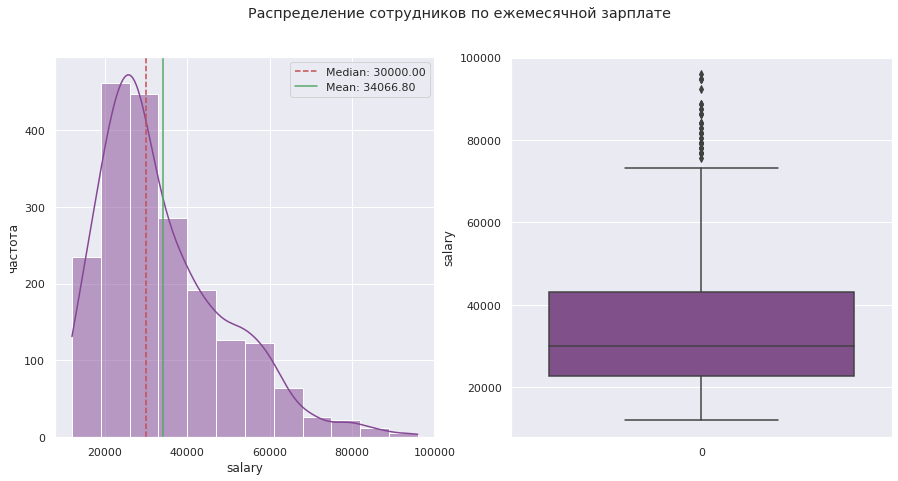

In [86]:
viz_num_character(df_test_job, 'salary', 'Распределение сотрудников по ежемесячной зарплате', 12)

Имеются выбросы, но не считаю их аномальными значениями, т.к. специалисты высокого уровня и занимаемой должности высокооплачиваемы. Минимальная зарплата в компании составляет 12000, максимальная - 96000. Среднее значение - 34066.8, медиана - 30000.0.

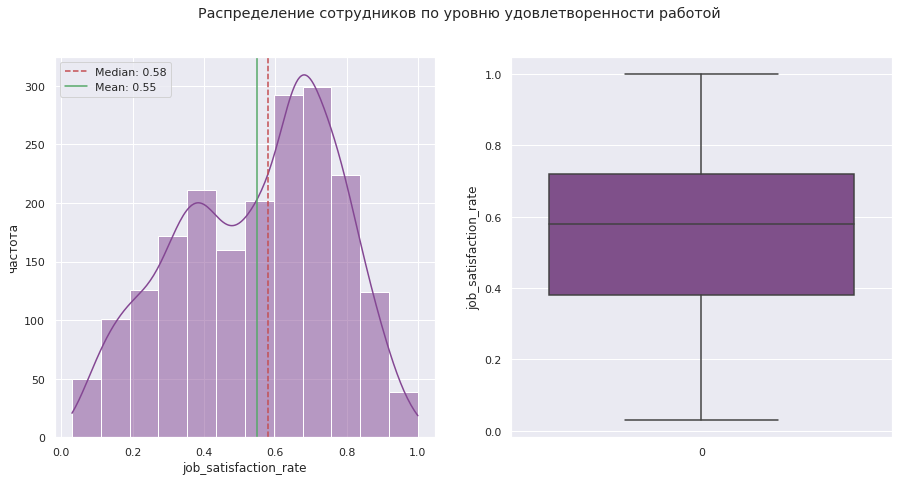

In [87]:
viz_num_character(df_test_job, 'job_satisfaction_rate', 'Распределение сотрудников по уровню удовлетворенности работой', 12)

Доля удовлетворенности сотрудников рассчитывается от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. В тестовой выборке мы имеем средний уровень удовлетворенности 0.55, медианное значение - 0.58.

##### Датафрейм df_test_target_quit (целевой признак тестовой выборки)

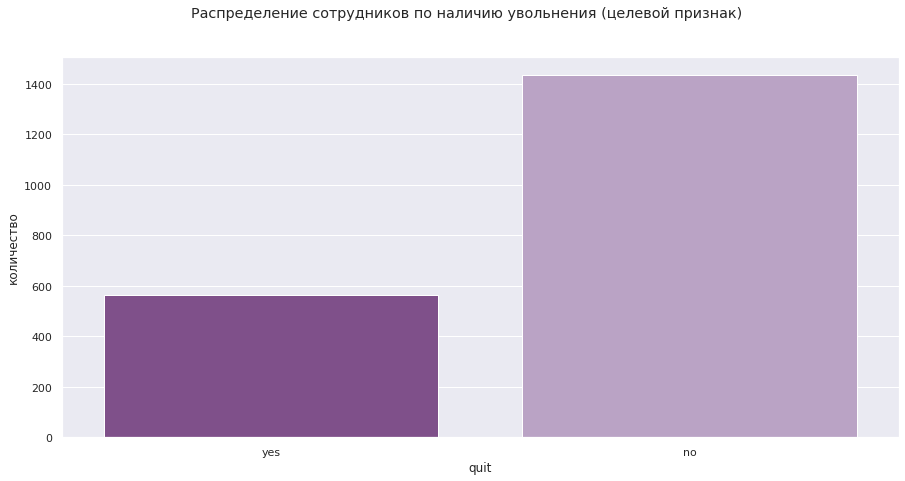

no     1436
yes     564
Name: quit, dtype: int64


In [88]:
viz_bar_character(df_test_target_quit, 'quit', 'Распределение сотрудников по наличию увольнения (целевой признак)')

Имеем дисбаланс целевого признака, это нужно учесть при моделировании. Уволившихся сотрудников 564 и действующих - 1436.

#### Портрет "уволившегося сотрудника"

Составим портрет уволившегося сотрудника. Для этого отберем всех уволившихся сотрудников из тренировочной выборки и сохраним их в df_train_quit_yes, оставшихся сотрудников сохраним в df_train_quit_no:

In [89]:
df_train_quit_yes = df_train_quit.query('quit == "yes"')
df_train_quit_yes.sample(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
1517,945520,sales,junior,low,1,no,yes,3,14400,yes
3387,629348,purchasing,senior,medium,5,no,no,4,60000,yes
3987,438954,sales,junior,medium,2,no,no,3,24000,yes


In [90]:
df_train_quit_no = df_train_quit.query('quit == "no"')
df_train_quit_no.sample(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2515,955960,purchasing,middle,medium,7,no,no,3,33600,no
151,474550,sales,middle,low,8,no,no,4,19200,no
2129,492474,purchasing,senior,high,8,no,no,4,67200,no


Проведем анализ для составления портрета "уволившегося сотрудника":

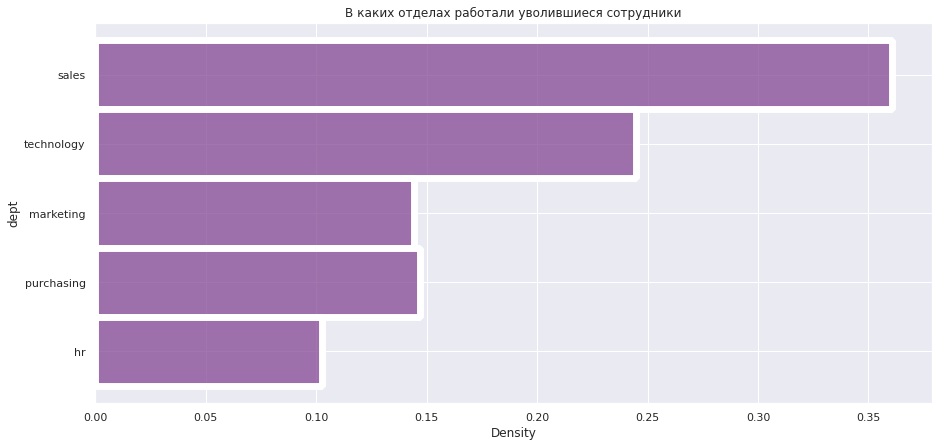

,dept,percent
0,sales,36.081560
1,technology,24.468085
2,purchasing,14.716312
3,marketing,14.450355
4,hr,10.283688


In [91]:
sns.histplot(data=df_train_quit_yes, y='dept', stat='density', common_norm=False)
plt.title('В каких отделах работали уволившиеся сотрудники')
plt.show()

df_quit_yes_dept = (df_train_quit_yes['dept'].value_counts(normalize=True) * 100)
df_quit_yes_dept.rename_axis('dept').reset_index(name='percent')

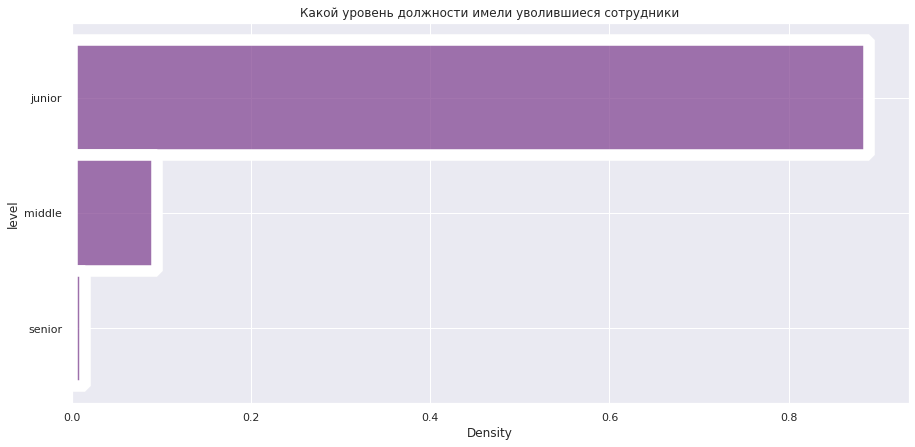

,level,percent
0,junior,88.918440
1,middle,9.574468
2,senior,1.507092


In [92]:
sns.histplot(data=df_train_quit_yes, y='level', stat='density', common_norm=False)
plt.title('Какой уровень должности имели уволившиеся сотрудники')
plt.show()

df_quit_yes_level = (df_train_quit_yes['level'].value_counts(normalize=True) * 100)
df_quit_yes_level.rename_axis('level').reset_index(name='percent')

Почти 90% уволившихся сотрудников были на начальном уровне карьеры - 'junior'.

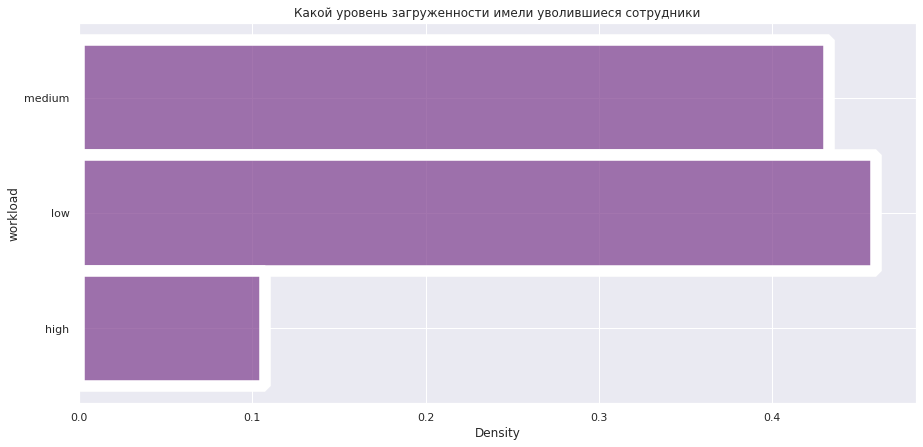

,workload,percent
0,low,46.010638
1,medium,43.262411
2,high,10.726950


In [93]:
sns.histplot(data=df_train_quit_yes, y='workload', stat='density', common_norm=False)
plt.title('Какой уровень загруженности имели уволившиеся сотрудники')
plt.show()

df_quit_yes_workload = (df_train_quit_yes['workload'].value_counts(normalize=True) * 100)
df_quit_yes_workload.rename_axis('workload').reset_index(name='percent')

Почти все уволившиеся сотрудники имели средний (43%) и низкий (46%) уровни загруженности.

In [94]:
df_quit_yes_promo = (df_train_quit_yes['last_year_promo'].value_counts(normalize=True) * 100)
print('Имели ли повышение за последний год уволившиеся сотрудники:')
df_quit_yes_promo.rename_axis('last_year_promo').reset_index(name='percent')

Имели ли повышение за последний год уволившиеся сотрудники:


,last_year_promo,percent
0,no,99.911348
1,yes,0.088652


In [95]:
df_quit_yes_employment = (df_train_quit_yes['employment_years'].value_counts(normalize=True) * 100)
print('Сколько лет проработали уволившиеся сотрудники:')
df_quit_yes_employment.rename_axis('employment_years').reset_index(name='percent')

Сколько лет проработали уволившиеся сотрудники:


,employment_years,percent
0,1,53.102837
1,2,25.709220
2,3,14.450355
3,4,2.393617
4,5,2.039007
5,6,0.886525
6,7,0.620567
7,8,0.265957
8,9,0.265957
9,10,0.265957


In [96]:
df_quit_yes_violations = (df_train_quit_yes['last_year_violations'].value_counts(normalize=True) * 100)
print('Имели ли нарушение за последний год уволившиеся сотрудники:')
df_quit_yes_violations.rename_axis('last_year_violations').reset_index(name='percent')

Имели ли нарушение за последний год уволившиеся сотрудники:


,last_year_violations,percent
0,no,79.787234
1,yes,20.212766


In [97]:
df_quit_yes_evaluation = (df_train_quit_yes['supervisor_evaluation'].value_counts(normalize=True) * 100)
print('Какую оценку работы имели уволившиеся сотрудники:')
df_quit_yes_evaluation.rename_axis('supervisor_evaluation').reset_index(name='percent')

Какую оценку работы имели уволившиеся сотрудники:


,supervisor_evaluation,percent
0,3,46.365248
1,4,25.354610
2,2,14.539007
3,1,8.421986
4,5,5.319149


In [98]:
print('Средняя зарплата уволившегося сотрудника: ', df_train_quit_yes['salary'].mean().round(2))
print('Медианная зарплата уволившегося сотрудника: ', df_train_quit_yes['salary'].median())

Средняя зарплата уволившегося сотрудника:  23885.11
Медианная зарплата уволившегося сотрудника:  22800.0


Можно сформировать **портрет уволившегося сотрудника**: работал в отделе продаж на уровне должности 'junior' не больше 1 года, имел низкую или среднюю загруженность и не имел повышения за год работы, нарушений трудоговора договора не было. По оценке руководителя, качество работы сотрудника было на уровне 3 баллов из 5. Зарплата составляла в среднем 23885.

Сравним уровень зарплаты ушедших сотрудников с оставшимися:

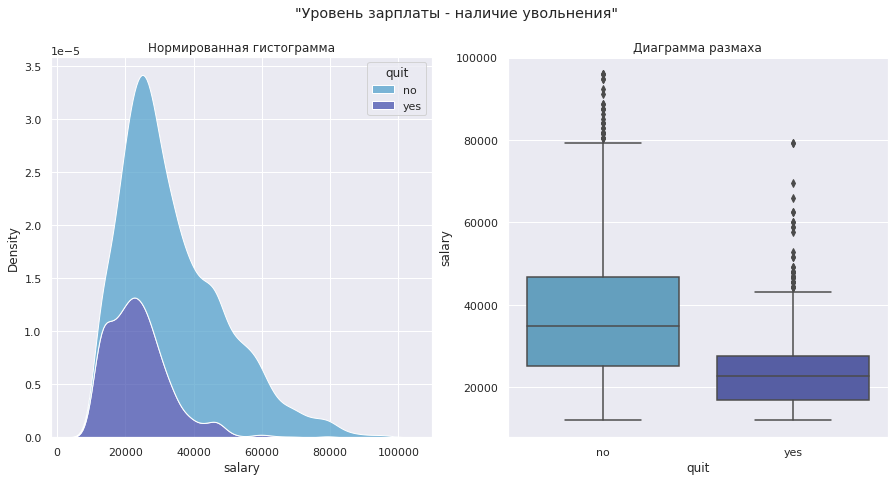


Средняя зарплата уволившихся сотрудников: 23885.11
Средняя зарплата оставшихся сотрудников: 37702.23
Медианная зарплата уволившихся сотрудников: 22800.0
Медианная зарплата оставшихся сотрудников: 34800.0



In [99]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_palette('icefire')
fig, axes = plt.subplots(1, 2)

sns.kdeplot(data=df_train_quit, x='salary', hue='quit', ax=axes[0], multiple="stack")
axes[0].set(xlabel='salary')
axes[0].set_title('Нормированная гистограмма')

sns.boxplot(data=df_train_quit, x='quit', y='salary', ax=axes[1])
axes[1].set(ylabel='salary')
axes[1].set_title('Диаграмма размаха')
plt.suptitle('"Уровень зарплаты - наличие увольнения"')
plt.show()

print(f'''
Средняя зарплата уволившихся сотрудников: {df_train_quit_yes['salary'].mean().round(2)}
Средняя зарплата оставшихся сотрудников: {df_train_quit_no['salary'].mean().round(2)}
Медианная зарплата уволившихся сотрудников: {df_train_quit_yes['salary'].median()}
Медианная зарплата оставшихся сотрудников: {df_train_quit_no['salary'].median()}
''')

Видим заметную разницу в зарплатах. Те, кто остался, имеют значительно большую оплату труда, чем имели те, кто уволился. Посчитаем разницу в зарплатах:

In [100]:
delta = (df_train_quit_no['salary'].mean() - df_train_quit_yes['salary'].mean()) / (df_train_quit_yes['salary'].mean()) * 100

print(f'Зарплата уволившихся сотрудников меньше оставшихся на {delta.round(2)}%')

Зарплата уволившихся сотрудников меньше оставшихся на 57.85%


#### Связь уровня удовлетворенности работой и увольнений

Предположим, что целевой признак из 1 задачи 'job_satisfaction_rate' (уровень удовлетворенности работой) и целевой признак из 2 задачи 'quit' (увольнение сотрудника из компании) связаны. Для проверки данного утверждения в тестовую выборку df_test_quit добавим целевой признак 'quit'. Тестовая выборка df_test_job уже содержит целевой признак из 1 задачи:

In [101]:
df_test_quit = df_test_job.merge(df_test_target_quit, on='id', how='left')
print('Размерность нового датафрейма df_test_job после объединения:', df_test_job.shape)
df_test_quit.head()

Размерность нового датафрейма df_test_job после объединения: (2000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


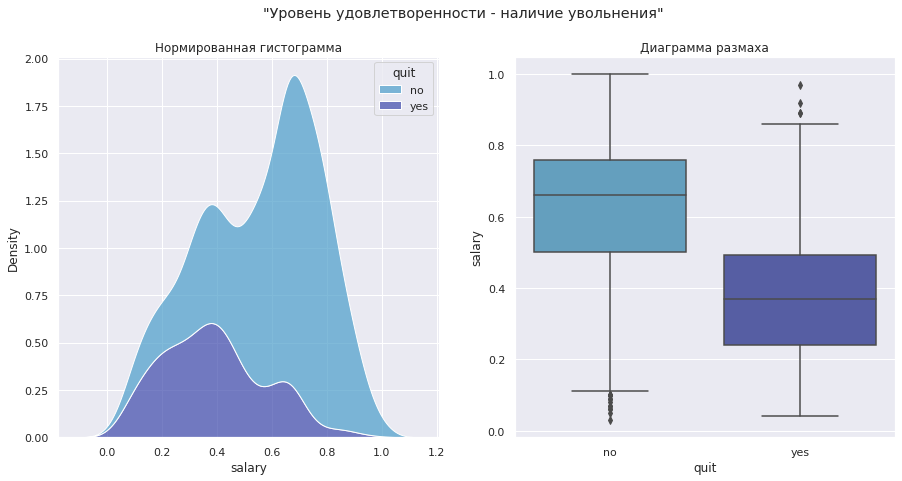


Средний уровень удовлетворенности уволившихся сотрудников: 0.39
Средний уровень удовлетворенности оставшихся сотрудников: 0.61



In [102]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_palette('icefire')
fig, axes = plt.subplots(1, 2)

sns.kdeplot(data=df_test_quit, x='job_satisfaction_rate', hue='quit', ax=axes[0], multiple="stack")
axes[0].set(xlabel='salary')
axes[0].set_title('Нормированная гистограмма')

sns.boxplot(data=df_test_quit, x='quit', y='job_satisfaction_rate', ax=axes[1])
axes[1].set(ylabel='salary')
axes[1].set_title('Диаграмма размаха')
plt.suptitle('"Уровень удовлетворенности - наличие увольнения"')
plt.show()

print(f'''
Средний уровень удовлетворенности уволившихся сотрудников: \
{df_test_quit[df_test_quit['quit'] == "yes"]['job_satisfaction_rate'].mean().round(2)}
Средний уровень удовлетворенности оставшихся сотрудников: \
{df_test_quit[df_test_quit['quit'] == "no"]['job_satisfaction_rate'].mean().round(2)}
''')

Предположение подтвердилось - увольнение сотрудников зависит от уровня их удовлетворенности работой: у уволившихся сотрудников уровень удовлетворенности ниже, чем у тех, кто остался работать дальше. Следовательно, признак "уровень удовлетворенности работой" поможет в решении данной задачи - поможет в прогнозировании увольнения. 

#### Вывод

Проведен исследовательский анализ данных, который дал представление о распределении признаков и их значениях.

- **Датафрейм df_train_quit (тренировочная выборка)**:

  - для обучения представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1432), меньше всего в отделе HR (464);
  - по уровням занимаемой должности:  junior (1949 чел), middle (1694 чел), senior (357 чел);
  - касательно уровня загруженности сотрудников, то почти половина из них (2118 чел) имеют среднюю степень, 674 человека с высоким уровнем загруженности и легче всего работается 1208 сотрудникам;
  - из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 4 года;
  - из общего числа сотрудников только 113 человек имели повышение за последний год;
  - 545 сотрудников из общего числа имеют нарушения по трудовому договору за последний год;
  - исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 520 человек, а 202 человека имеют самый низкий балл (1);
  - минимальная зарплата составляет 12000, максимальная - 96000. Среднее значение - 33805.8, медиана - 30000.0;
  - имеем данные, в которых информация об уволившихся сотрудниках (1128) и действующих (2872).
  
- **Датафрейм df_test_job (входные признаки тестовой выборки)**:
  - представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227);
  - по уровню занимаемой должности: junior (974 чел), middle (854 чел), senior (171 чел);
  - чуть больше половины сотрудников (1043 чел) имеют среднюю степень загруженности, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам;
  - длительность работы в компании от 1 до 10 лет. В среднем это 3.67, медиана - 3 года;
  - из общего числа представленных сотрудников, только 63 человека имели повышение за последний год;
  - 262 сотрудника имеют нарушения по трудовому договору за последний год;
  - иправно выполняющих свои должностные обязанности (по оценке руководителя) сотрудников (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1);
  - минимальная зарплата в выборке составляет 12000, максимальная - 96000. Среднее значение - 34066.8, медиана - 30000.0;
  - по данным имеем средний уровень удовлетворенности 0.55, медианное значение - 0.58.
  
- **Датафрейм df_test_target_quit (целевой признак тестовой выборки)**:
  - дисбаланс целевого признака, это нужно учесть при моделировании. Уволившихся сотрудников 564 и действующих - 1436.

Так же был составлен **портрет "уволившегося сотрудника"**: работал в отделе продаж на уровне должности 'junior' не больше 1 года, имел низкую или среднюю загруженность и не имел повышения за год работы, нарушений трудоговора договора не было. По оценке руководителя, качество работы сотрудника было на уровне 3 баллов из 5. Зарплата составляла в среднем 23885.

Проведено сравнение зарплаты оставшихся и уволившихся сотрудников: те, кто остался, имеют значительно бОльшую оплату труда (на 57.85% больше), чем имели те, кто уволился.

### Корреляционный анализ данных

#### Датафрейм df_train_quit (тренировочная выборка)

Построим матрицу корреляции признаков датафрейма df_train_quit и тепловую карту для ее визуализации:

In [103]:
# Вычисление матрицы корреляции с использованием phik
interval_cols = ['salary']

corr_matrix = df_train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
corr_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.000000,0.000000,0.000000,0.000000,0.000000,0.044274,0.042772,0.280300,0.000000
level,0.000000,1.000000,0.479480,0.692676,0.110585,0.000000,0.007189,0.745104,0.312799
workload,0.000000,0.479480,1.000000,0.213013,0.044388,0.014063,0.000000,0.793876,0.132243
employment_years,0.000000,0.692676,0.213013,1.000000,0.156494,0.000000,0.000000,0.491915,0.659093
last_year_promo,0.000000,0.110585,0.044388,0.156494,1.000000,0.000000,0.032376,0.215043,0.157370
last_year_violations,0.044274,0.000000,0.014063,0.000000,0.000000,1.000000,0.179228,0.086087,0.185071
supervisor_evaluation,0.042772,0.007189,0.000000,0.000000,0.032376,0.179228,1.000000,0.055330,0.245489
salary,0.280300,0.745104,0.793876,0.491915,0.215043,0.086087,0.055330,1.000000,0.564154
quit,0.000000,0.312799,0.132243,0.659093,0.157370,0.185071,0.245489,0.564154,1.000000


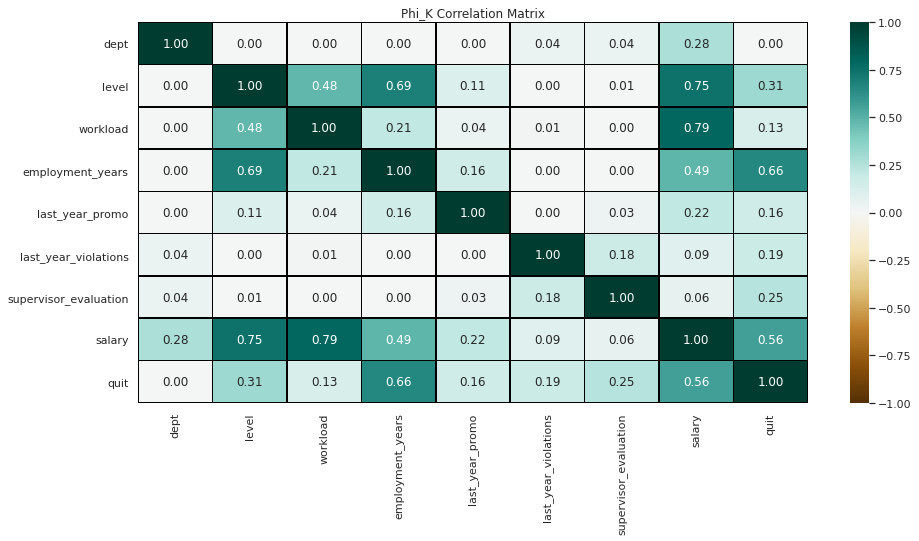

In [104]:
# визуализация - тепловая карта
sns.heatmap(corr_matrix, 
                annot=True, vmin=-1, vmax=1, center=0, cmap='BrBG', 
                linecolor='black', linewidths=0.5, fmt=".2f")
sns.set(rc={'figure.figsize': (15, 10)})
plt.title('Phi_K Correlation Matrix')
plt.show()

**Вывод**:

**Целевой признак коррелирует с входными признаки и наблюдается связь:**
- заметная:
  - длительность работы в компании (0.66);
  - ежемесячная зарплата сотрудника (0.56);
- умеренная;
  - уровень занимаемой должности (0.31);
- слабая:
  - повышение за последний год (0.16);
  - нарушение трудового договора (0.19);
  - оценка качества работы от руководителя (0.25);
  - уровень загруженности сотрудника (0.13)
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) не наблюдается.**

#### Датафрейм df_test_quit (тестовая выборка)

Построим матрицу корреляции признаков датафрейма df_test_quit и тепловую карту для ее визуализации:

In [105]:
# Вычисление матрицы корреляции с использованием phik
interval_cols = ['salary', 'job_satisfaction_rate']

corr_matrix = df_test_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
corr_matrix

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
dept,1.000000,0.000000,0.033894,0.000000,0.000000,0.000000,0.060917,0.330406,0.075774,0.000000
level,0.000000,1.000000,0.474151,0.689666,0.118258,0.017527,0.000000,0.748998,0.095706,0.293623
workload,0.033894,0.474151,1.000000,0.202240,0.035609,0.000000,0.036353,0.785849,0.052308,0.102151
employment_years,0.000000,0.689666,0.202240,1.000000,0.173637,0.066371,0.000000,0.494701,0.313525,0.605927
last_year_promo,0.000000,0.118258,0.035609,0.173637,1.000000,0.000000,0.011704,0.193727,0.337002,0.137762
last_year_violations,0.000000,0.017527,0.000000,0.066371,0.000000,1.000000,0.189719,0.000000,0.554811,0.174740
supervisor_evaluation,0.060917,0.000000,0.036353,0.000000,0.011704,0.189719,1.000000,0.114588,0.769857,0.294738
salary,0.330406,0.748998,0.785849,0.494701,0.193727,0.000000,0.114588,1.000000,0.171903,0.508308
job_satisfaction_rate,0.075774,0.095706,0.052308,0.313525,0.337002,0.554811,0.769857,0.171903,1.000000,0.610263
quit,0.000000,0.293623,0.102151,0.605927,0.137762,0.174740,0.294738,0.508308,0.610263,1.000000


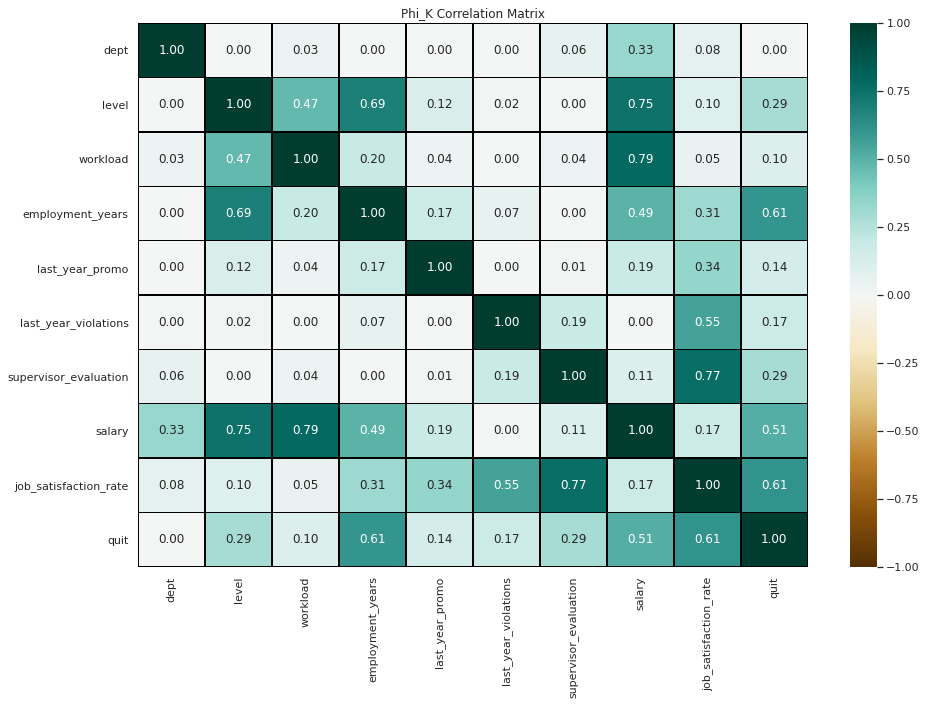

In [106]:
# визуализация - тепловая карта
sns.heatmap(corr_matrix, 
                annot=True, vmin=-1, vmax=1, center=0, cmap='BrBG', 
                linecolor='black', linewidths=0.5, fmt=".2f")
sns.set(rc={'figure.figsize': (15, 10)})
plt.title('Phi_K Correlation Matrix')
plt.show()

**Вывод**:

**Целевой признак коррелирует с входными признаки и наблюдается связь:**
- заметная:
  - длительность работы в компании (0.61);
  - ежемесячная зарплата сотрудника (0.51);
  - уровень удовлетворенности работой (0.61);
- слабая:
  - повышение за последний год (0.14);
  - нарушение трудового договора (0.17);
  - оценка качества работы от руководителя (0.29);
  - уровень загруженности сотрудника (0.10);
  - уровень занимаемой должности (0.29).
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) не наблюдается.**

### Добавление нового признака

На этапе исследовательского анализа данных (п.2.3.3) и корреляционного анализа (п.2.4) было выяснено, что уровень удовлетворенности работой влияет на вероятность увольнения сотрудника. Данный признак будет полезен в прогнозировании увольнения. Поэтому в тренировочную выборку df_train_quit добавим новый признак 'job_satisfaction_rate', значения которого получим с помощью лучшей модели из 1 задачи.

Спрогнозируем уровень удовлетворенности работой сотрудника и добавим результат прогноза в датафрейм df_train_quit:

In [107]:
df_train_quit['job_satisfaction_rate'] = grid_search.best_estimator_.predict(df_train_quit.drop(['quit'], axis=1))
df_train_quit.sample(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
3362,862221,marketing,middle,medium,6,no,no,4,46800,no,0.760
1174,954135,sales,junior,medium,4,no,no,5,27600,no,0.785
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.380


### Подготовка данных

Объединим датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id':

In [108]:
df_test_quit = df_test_job.merge(df_test_target_quit, on='id', how='left')
print('Размерность нового датафрейма df_test_quit после объединения:', df_test_quit.shape)
df_test_quit.head(3)

Размерность нового датафрейма df_test_quit после объединения: (2000, 11)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no


Проверим наличие явных дубликатов в тренировочной выборке, убрав из датафрейма 'id' - этот признак не предоставляет дополнительной информации для обучения модели, а лишь увеличивает вычислительные затраты и время обучения:

In [109]:
df_train_quit = df_train_quit.drop('id', axis=1)
print(f'Количество явных дубликатов без "id": {df_train_quit.duplicated().sum()}')

Количество явных дубликатов без "id": 1413


Удаляем дубликаты:

In [110]:
df_train_quit = df_train_quit.drop_duplicates().reset_index(drop=True)
print(f'Количество явных дубликатов после удаления: {df_train_quit.duplicated().sum()}')
print(f'Размерность датафрeйма после удаления: {df_train_quit.shape}')

Количество явных дубликатов после удаления: 0
Размерность датафрeйма после удаления: (2587, 10)


Определяем выборки:

In [111]:
X_train_2 = df_train_quit.drop('quit', axis=1)
X_test_2 = df_test_quit.drop(['id', 'quit'], axis=1)
y_train_2 = df_train_quit['quit']
y_test_2 = df_test_quit['quit']

# проверяем разделение на выборки:
print(f'''
Размерность X_train_2: {X_train_2.shape}
Размерность X_test_2: {X_test_2.shape}
Размерность y_train_2: {y_train_2.shape}
Размерность y_test_2: {y_test_2.shape}
''')


Размерность X_train_2: (2587, 9)
Размерность X_test_2: (2000, 9)
Размерность y_train_2: (2587,)
Размерность y_test_2: (2000,)



Разделение прошло верно.

**Согласно исследовательскому анализу данных, мы имеем дисбаланс целевого признака, поэтому для компенсации дисбаланса добавим class_weight='balanced' напрямую в конструкторы моделей, которые это поддерживают**.

Кодируем целевой признак:

In [112]:
# кодируем целевой признак
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

# смотрим какому значению целевого признака какой код присвоен
print('Код значения целевого признака:')
for code, category in enumerate(label_encoder.classes_):
    print(f'Код {code}: Значение "{category}"')

Код значения целевого признака:
Код 0: Значение "no"
Код 1: Значение "yes"


Создаем списки с признаками для обработки:

In [113]:
# для OneHotEncoder 
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# для OrdinalEncoder
ord_columns = ['level', 'workload']

# для масштабирования 
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Применяем пайплайн:

In [114]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

**Вывод**: на этапе подготовки данных было выполнено:

- объединены датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id';
- удалены явные дубликаты (1413);
- определены выборки для моделирования, созданы списки с признаками для обработки. Целевой признак закодирован с помощью LabelEncoder. Кодирование входных признаков осуществлялось с помощью OneHotEncoder и OrdinalEncoder;
- создан пайплайн, включащий в себя этапы:
   - пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder);
   - пайплайн ord_pipe, который включает в себя шаги: simpleImputer_ord (заполняет пропуски, если они есть, самым частым встречающимся значением) и ord (кодирование с помощью OrdinalEncoder);
   - общий пайплайн подготовки данных data_preprocessor, который объединит пайплайны обработки категориальных признаков и масштабирование количественных признаков (MinMaxScaler);
   - итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели дерева решений - DecisionTreeClassifier.

### Обучение моделей

#### Поиск лучшей модели

Выберем лучшую модель и проверим её качество на основе **метрики ROC-AUC** (критерий успеха: ROC-AUC≥0.91 на тестовой выборке), так как она является одной из наиболее информативных метрик в задачах классификации, особенно при работе с несбалансированными классами.

Подберем лучшие гиперпараметры и методы подготовки данных. Создадим список словарей для каждой модели в param_grid_quit. Возьмем 3 модели: DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression. 

Для компенсации дисбаланса добавим class_weight='balanced' в конструкторы моделей, которые это поддерживают:

In [115]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__max_features': range(1, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

param_grid_quit

[{'models': [DecisionTreeClassifier(random_state=42)],
  'models__max_depth': range(1, 10),
  'models__max_features': range(1, 10),
  'models__class_weight': [None, 'balanced'],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [KNeighborsClassifier()],
  'models__n_neighbors': range(1, 10),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LogisticRegression(penalty='l1', random_state=42, solver='liblinear')],
  'models__C': range(1, 10),
  'models__class_weight': [None, 'balanced'],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

Для поиска модели с гиперпараметрами используем автоматизированный поиск по сетке GridSearchCV:

In [116]:
grid_search_quit = GridSearchCV(
    pipe_final,
    param_grid=param_grid_quit,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

grid_search_quit.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_)
print()
print('Параметры лучшей модели:', grid_search_quit.best_params_)
print()
print('Метрика ROC-AUC лучшей модели на кросс-валидации на обучающих данных:', grid_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

Найдена лучшая модель и ее гиперпаметры. Но критерий успеха ROC-AUC≥0.91 не достигнут. Для дальнейшего улучшения модели необходимо отобрать признаки.

**Вывод**: на этапе поиска лучшей модели было выполнено:

- создадан список словарей для каждой модели в param_grid_quit. Взяты для обучения 3 модели: DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression. Для компенсации дисбаланса добавлен class_weight='balanced' в конструкторы моделей, которые это поддерживают;
- для поиска модели с гиперпараметрами использован автоматизированный поиск по сетке GridSearchCV;
- в качестве оценки качества модели выбрана метрика ROC-AUC (критерий успеха: ROC-AUC≥0.91 на тестовой выборке).


При помощи GridSearchCV найдена **лучшая модель и ее гиперпараметры**: LogisticRegression(penalty='l1', random_state=42, solver='liblinear', С=1, class_weight='balanced') с методом масштабирования количественных признаков StandardScaler().

**Метрика ROC-AUC лучшей модели на кросс-валидации на обучающих данных: 0.903**

Критерий успеха ROC-AUC≥0.91 не достигнут. Данная модель не обладает достаточным качеством. 
Необходимо произвести отбор признаков, удалить наименее важные, обучить и найти более лучшую модель и гиперпараметры, которые покажут более высокий результат.

#### Отбор признаков и их важность

Оценим важность признаков для лучшей модели, построим график важности с помощью метода SHAP.

In [117]:
# лучший пайплайн лучшей модели
best_pipe = grid_search_quit.best_estimator_

# обрабатываем данные шагом 'preprocessor' из лучшего пайплайна лучшей модели
X_train_3 = best_pipe.named_steps['preprocessor'].fit_transform(X_train_2)
X_test_3 = best_pipe.named_steps['preprocessor'].transform(X_test_2)

# строим SHAP
explainer = shap.Explainer(best_pipe.named_steps['models'], X_train_3, 
                           feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out())
shap_values = explainer(X_test_3)

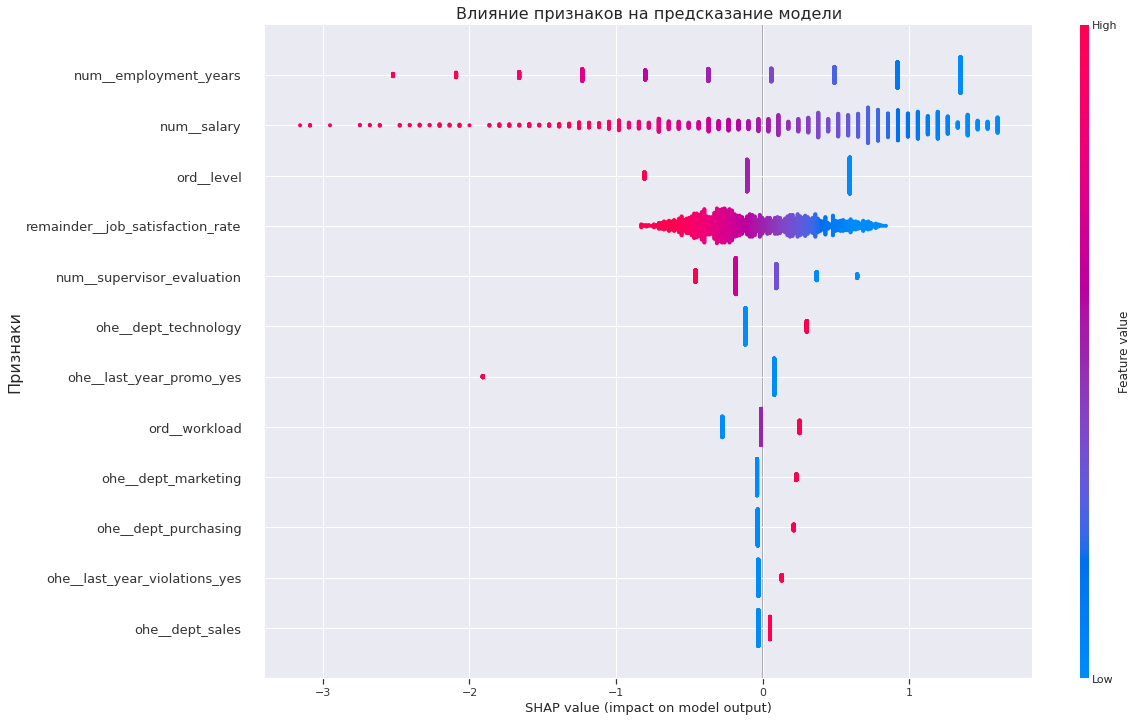

In [118]:
shap.summary_plot(shap_values, X_test_3, plot_size=(17,10), show=False)
plt.ylabel('Признаки', fontsize=16)
plt.title('Влияние признаков на предсказание модели', fontsize=16)
plt.show()

Данный график отображает вклад каждого признака в предсказания модели по всему набору тестовых данных: 
- Каждая точка – отдельное наблюдение;
- Цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим;
- Признаки расположены на оси Oy по мере уменьшения их важности;
- По оси Ox находятся значения Шепли, которые влияют на отнесение к классу либо положительно, либо отрицательно.

Целевой признак был преобразован в бинарный: значение 0 - увольнения не было, значение 1 - сотрудник уволился.

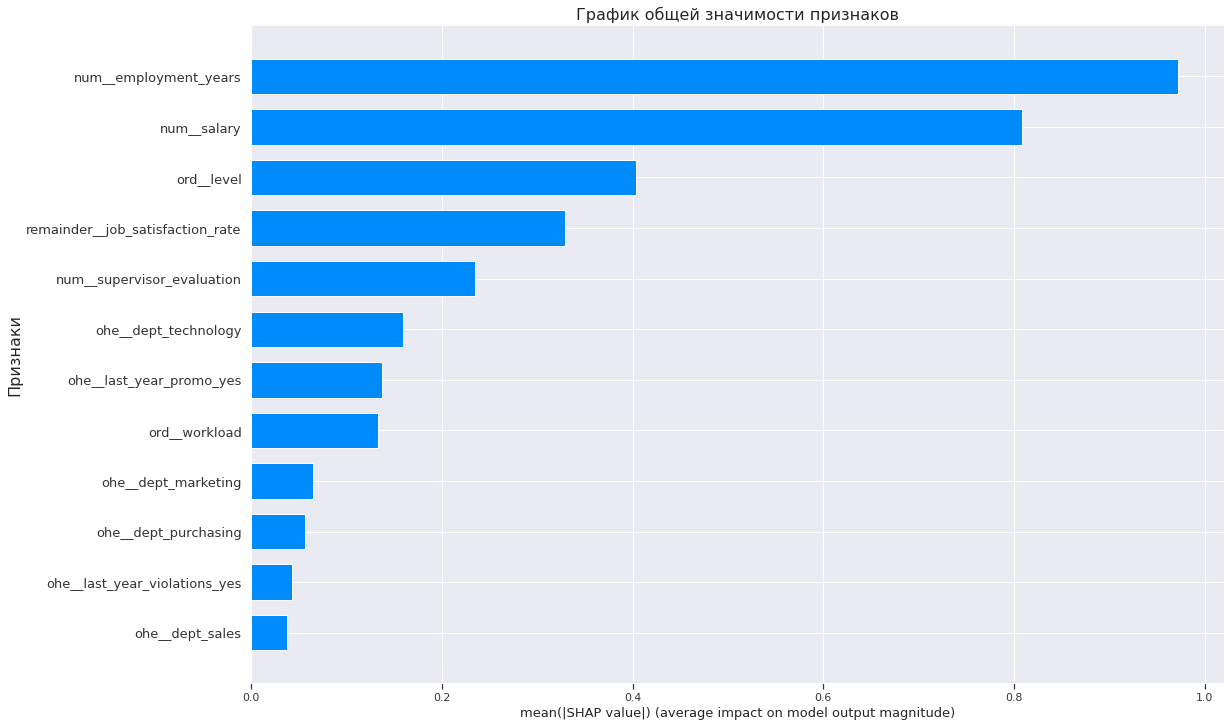

In [119]:
shap.summary_plot(shap_values, X_test_3, plot_type='bar', plot_size=(17,10), show=False)
plt.ylabel('Признаки', fontsize=16)
plt.title('График общей значимости признаков', fontsize=16)
plt.show()

Самые значимые 5 признаков для модели:
- длительность работы в компании;
- ежемесячная зарплата сотрудника;
- уровень занимаемой должности;
- уровень удовлетворенности работой;
- оценка качества работы от руководителя.

Наименее значимые 5 признаков:
- наличие нарушения трудового договора;
- наименование отдела, в котором работает сотрудник (отдел продаж);
- наименование отдела, в котором работает сотрудник (отдел закупок);
- наименование отдела, в котором работает сотрудник (отдел маркетинга);
- уровень загруженности сотрудника.

Создаем функцию для формирования таблицы важности признаков по методу Шепли:

In [120]:
def global_shap_importance(shap_values):
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
            
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values( by=['importance'], ascending=False, inplace=True)
    
    return feature_importance

In [121]:
global_shap_importance(shap_values)

,features,importance
8,num__employment_years,0.972008
10,num__salary,0.808186
6,ord__level,0.404109
11,remainder__job_satisfaction_rate,0.329061
9,num__supervisor_evaluation,0.234613
3,ohe__dept_technology,0.159653
4,ohe__last_year_promo_yes,0.137131
7,ord__workload,0.132594
0,ohe__dept_marketing,0.064348
1,ohe__dept_purchasing,0.056481


В таблице представлены все признаки, влияющие на предсказания модели, в порядке убывания важности.

Удалим наименее важные признаки: 'dept', 'last_year_violations' и запустим поиск новой лучшей модели:

In [122]:
df_train_quit_new = df_train_quit.drop(['last_year_violations', 'dept'], axis=1)
df_test_quit_new = df_test_quit.drop('id', axis=1)

Определяем выборки:

In [123]:
X_train_new = df_train_quit_new.drop('quit', axis=1)
X_test_new = df_test_quit_new.drop('quit', axis=1)
y_train_new = df_train_quit_new['quit']
y_test_new = df_test_quit_new['quit']

# проверяем разделение на выборки:
print(f'''
Размерность X_train_new: {X_train_new.shape}
Размерность X_test_new: {X_test_new.shape}
Размерность y_train_new: {y_train_new.shape}
Размерность y_test_new: {y_test_new.shape}
''')


Размерность X_train_new: (2587, 7)
Размерность X_test_new: (2000, 9)
Размерность y_train_new: (2587,)
Размерность y_test_new: (2000,)



In [124]:
# кодируем целевой признак
label_encoder = LabelEncoder()
y_train_new = label_encoder.fit_transform(y_train_new)
y_test_new = label_encoder.transform(y_test_new)

# смотрим какому значению целевого признака какой код присвоен
print('Код значения целевого признака:')
for code, category in enumerate(label_encoder.classes_):
    print(f'Код {code}: Значение "{category}"')

Код значения целевого признака:
Код 0: Значение "no"
Код 1: Значение "yes"


Создаем списки признаков для обработки и собираем пайплайн:

In [125]:
# для OneHotEncoder 
ohe_columns = ['last_year_promo']

# для OrdinalEncoder
ord_columns = ['level', 'workload']

# для масштабирования 
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

In [126]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)


# SimpleImputer + OrdinalEncoder
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
) 

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Создадим список словарей для каждой модели:

In [127]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__max_features': range(1, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

param_grid_quit

[{'models': [DecisionTreeClassifier(random_state=42)],
  'models__max_depth': range(1, 10),
  'models__max_features': range(1, 10),
  'models__class_weight': [None, 'balanced'],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [KNeighborsClassifier()],
  'models__n_neighbors': range(1, 10),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LogisticRegression(penalty='l1', random_state=42, solver='liblinear')],
  'models__C': range(1, 10),
  'models__class_weight': [None, 'balanced'],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

Запускаем поиск новой модели:

In [128]:
grid_search_quit = GridSearchCV(
    pipe_final,
    param_grid=param_grid_quit,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

grid_search_quit.fit(X_train_new, y_train_new)

print('Лучшая модель и её параметры:\n\n', grid_search_quit.best_estimator_)
print()
print('Параметры лучшей модели:', grid_search_quit.best_params_)
print()
print('Метрика ROC-AUC лучшей модели на кросс-валидации на обучающих данных:', grid_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                

Проверяем качество новой лучшей модели на тестовых данных:

In [129]:
y_test_proba = grid_search_quit.best_estimator_.predict_proba(X_test_new)[:, 1]
print('Метрика ROC-AUC новой лучшей модели на тестовой выборке:', roc_auc_score(y_test_new, y_test_proba).round(3))

Метрика ROC-AUC новой лучшей модели на тестовой выборке: 0.926


Критерий успеха достигнут, метрика ROC-AUC новой лучшей модели на тестовой выборке: 0.926.

Таким образом, при удалении наименее важных признаков ('dept', 'last_year_violations') и при повторном запуске автоматизированного поиска (GridSearchCV) лучшей модели и гиперпараметров, была найдена новая лучшая модель, которая показала лучший результат, чем логистическая регрессия при первом запуске поиска. 

**Лучшая модель для задачи 2 выбрана: KNeighborsClassifier(n_neighbors=9) с масштабированием количественных признаков MinMaxScaler.**

**Метрика ROC-AUC лучшей модели на тестовых данных: 0.926 - критерий успеха достигнут**.

**Проверка лучшей модели на адекватность**.

Для проверки модели на адекватность будем использовать классификатор DummyClassifier:

In [130]:
# Создаем экземпляр DummyClassifier
dummy_model_2 = DummyClassifier(random_state=RANDOM_STATE)

# Обучаем DummyClassifier на тренировочных данных
dummy_model_2.fit(X_train_new, y_train_new)

# Предсказываем вероятности принадлежности к положительному классу с помощью DummyClassifier на тестовых данных
dummy_model_proba = dummy_model_2.predict_proba(X_test_new)[:,1]

# Вычисляем ROC-AUC с помощью DummyClassifier на тестовых данных
dummy_roc_auc = roc_auc_score(y_test_new, dummy_model_proba)
print('Метрика ROC-AUC dummy:', dummy_roc_auc.round(3))
print(f'Метрика ROC-AUC новой лучшей модели на тестовой выборке: {roc_auc_score(y_test_new, y_test_proba).round(3)}')

Метрика ROC-AUC dummy: 0.5
Метрика ROC-AUC новой лучшей модели на тестовой выборке: 0.926


Сравнение показывает, что выбранная новая лучшая модель значительно превосходит базовую, предложенную DummyClassifier, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи.

**Вывод**: на этапе отбора признаков и определения их важности было выполнено:

- оценена важность признаков для лучшей модели, построен график важности с помощью метода SHAP. Выделены:
  - самые значимые 5 признаков для модели:
   - длительность работы в компании;
   - ежемесячная зарплата сотрудника;
   - уровень занимаемой должности;
   - уровень удовлетворенности работой;
   - оценка качества работы от руководителя.

  - наименее значимые 5 признаков:
   - наличие нарушения трудового договора;
   - наименование отдела, в котором работает сотрудник (отдел продаж);
   - наименование отдела, в котором работает сотрудник (отдел закупок);
   - наименование отдела, в котором работает сотрудник (отдел маркетинга);
   - уровень загруженности сотрудника.
   
- создана таблица со всеми признаками, влияющими на предсказания модели, в порядке убывания важности по методу Шепли;
- отобраны наименее важные признаки: 'dept', 'last_year_violations', которые были удалены из обучающей выборки;
- повторно запущено обучение и поиск лучшей модели с гиперпараметрами после удаления признаков.

В результате была найдена новая лучшая модель, которая показала лучший результат, чем логистическая регрессия при первом запуске поиска. 

**Лучшая модель для задачи 2 выбрана: KNeighborsClassifier(n_neighbors=9) с масштабированием количественных признаков MinMaxScaler.**

**Метрика ROC-AUC лучшей модели на тестовых данных: 0.926 - критерий успеха достигнут**.

Данная модель прошла проверку на адекватность с помощью DummyClassifier, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи.

### Общий вывод

**РЕАЛИЗАЦИЯ ЗАДАЧИ ПО ЭТАПАМ**:

1. **Загрузка данных, изучение информации**:
- датафрейм df_train_quit с тренировочными данными 4000 строк, 10 столбцов. Пропусков нет.
- датафрейм df_test_job с входными признаками тестовой выборки 2000 строк, 10 столбцов. Есть пропуски (датафрейм из задачи 1).
- датафрейм df_train_quit с целевым признаком тестовой выборки 2000 строк, 2 столбца. Пропусков нет.

Названия столбцов записаны корректно, исправлений не требуется. Типы данных верные.

2. **Предобработка данных**:
Этап предобработки данных проведен для тренировочных данных в датафрейме df_train_quit. Датафрейм df_test_target_quit содержит бинарный целевой признак, пропусков нет, предобработка не требуется. Датафрейм с тестовой выборкой входных признаков прошел этап предобработки в задаче 1, в нем имеются пропуски, которые будут обработаны в пайплайне.
 - **Проверка наличия явных дубликатов**. Не обнаружено;
 - **Проверка наличия неявных дубликатов, ошибок**. 
    - орфографическая ошибка исправлена с 'sinior' на 'senior';
    - изменение типов данных не требуется.

3. **Исследовательский анализ данных**:
- **Датафрейм df_train_quit (с тренировочной выборкой)**:

  - для обучения представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (1432), меньше всего в отделе HR (464);
  - по уровням занимаемой должности:  junior (1949 чел), middle (1694 чел), senior (357 чел);
  - касательно уровня загруженности сотрудников, то почти половина из них (2118 чел) имеют среднюю степень, 674 человека с высоким уровнем загруженности и легче всего работается 1208 сотрудникам;
  - из представленных данных для исследования, мы имеем сотрудников с длительностью работы в компании от 1 до 10 лет. В среднем это 3.7, медиана - 4 года;
  - из общего числа сотрудников только 113 человек имели повышение за последний год;
  - 545 сотрудников из общего числа имеют нарушения по трудовому договору за последний год;
  - исправно выполняющих свои должностные обязанности сотрудников (на 5 даллов) - 520 человек, а 202 человека имеют самый низкий балл (1);
  - минимальная зарплата составляет 12000, максимальная - 96000. Среднее значение - 33805.8, медиана - 30000.0;
  - имеем данные, в которых информация об уволившихся сотрудниках (1128) и действующих (2872).
  
- **Датафрейм df_test_job (входные признаки тестовой выборки)**:
  - представлены данные о сотрудниках из 5 отделов: продажи, HR, технологии, закупок и маркетинга. Больше всего сотрудников в отделе продаж (763), меньше всего в отделе HR (227);
  - по уровню занимаемой должности: junior (974 чел), middle (854 чел), senior (171 чел);
  - чуть больше половины сотрудников (1043 чел) имеют среднюю степень загруженности, 363 человека с высоким уровнем загруженности и легче всего работается 593 сотрудникам;
  - длительность работы в компании от 1 до 10 лет. В среднем это 3.67, медиана - 3 года;
  - из общего числа представленных сотрудников, только 63 человека имели повышение за последний год;
  - 262 сотрудника имеют нарушения по трудовому договору за последний год;
  - иправно выполняющих свои должностные обязанности (по оценке руководителя) сотрудников (на 5 даллов) - 284 человека, а 88 человек имеют самый низкий балл (1);
  - минимальная зарплата в выборке составляет 12000, максимальная - 96000. Среднее значение - 34066.8, медиана - 30000.0;
  - по данным имеем средний уровень удовлетворенности 0.55, медианное значение - 0.58.
  
- **Датафрейм df_test_target_quit (целевой признак тестовой выборки)**:
  - дисбаланс целевого признака, это нужно учесть при моделировании. Уволившихся сотрудников 564 и действующих - 1436.

Так же был составлен **портрет "уволившегося сотрудника"**: работал в отделе продаж на уровне должности 'junior' не больше 1 года, имел низкую или среднюю загруженность и не имел повышения за год работы, нарушений трудоговора договора не было. По оценке руководителя, качество работы сотрудника было на уровне 3 баллов из 5. Зарплата составляла в среднем 23885.

Проведено сравнение зарплаты оставшихся и уволившихся сотрудников: те, кто остался, имеют значительно бОльшую оплату труда (на 57.85% больше), чем имели те, кто уволился.

Было выяснено, что увольнение сотрудников зависит от уровня их удовлетворенности работой: у уволившихся сотрудников уровень удовлетворенности ниже, чем у тех, кто остался работать дальше. Следовательно, признак "уровень удовлетворенности работой" поможет в решении данной задачи - поможет в прогнозировании увольнения. Для данного анализа были объединены входные признаки тестовой выборки с целевым признаком тестовой выборки в датафрейм df_test_quit.

4. **Корреляционный анализ данных**:

- **Датафрейм df_train_quit с тренировочной выборкой**. Целевой признак коррелирует с входными признаки и наблюдается связь:
  - заметная:
    - длительность работы в компании (0.66);
    - ежемесячная зарплата сотрудника (0.56);
  - умеренная;
    - уровень занимаемой должности (0.31);
  - слабая:
    - повышение за последний год (0.16);
    - нарушение трудового договора (0.19);
    - оценка качества работы от руководителя (0.25);
    - уровень загруженности сотрудника (0.13)

- **Датафрейм df_test_quit c тестовой выборкой**. Целевой признак коррелирует с входными признаки и наблюдается связь:**
  - заметная:
    - длительность работы в компании (0.61);
    - ежемесячная зарплата сотрудника (0.51);
    - уровень удовлетворенности работой (0.61);
  - слабая:
    - повышение за последний год (0.14);
    - нарушение трудового договора (0.17);
    - оценка качества работы от руководителя (0.29);
    - уровень загруженности сотрудника (0.10);
    - уровень занимаемой должности (0.29).
  
**Мультиколлинеарности между признаками (корреляция свыше 0.9) в обоих датафреймах не наблюдается.**

5. **Добавление нового признака**.

На этапе исследовательского и корреляционного анализов данных было выяснено, что уровень удовлетворенности работой влияет на вероятность увольнения сотрудника. Решено, что данный признак будет полезен в прогнозировании увольнения. Поэтому в тренировочную выборку df_train_quit добавлен новый признак 'job_satisfaction_rate', значения которого получены (спрогнозированы) с помощью лучшей модели из 1 задачи.

6. **Подготовка данных**:

- объединены датафрейм с тестовой выборкий (входные признаки) и тестовый датафрейм с целевым признаком по 'id';
- удалены явные дубликаты (1413), обнаруженные при удалении 'id';
- определены выборки для моделирования, созданы списки с признаками для обработки. Целевой признак закодирован с помощью LabelEncoder. Кодирование входных признаков осуществлялось с помощью OneHotEncoder и OrdinalEncoder;
- создан пайплайн, включащий в себя этапы:
   - пайплайн ohe_pipe, который включает в себя шаги: simpleImputer_ohe (заполняет пропуски, если они есть, самым частым встречающимся значением) и ohe (кодирование с помощью OneHotEncoder);
   - пайплайн ord_pipe, который включает в себя шаги: simpleImputer_ord (заполняет пропуски, если они есть, самым частым встречающимся значением) и ord (кодирование с помощью OrdinalEncoder);
   - общий пайплайн подготовки данных data_preprocessor, который объединит пайплайны обработки категориальных признаков и масштабирование количественных признаков (MinMaxScaler);
   - итоговый пайплайн pipe_final, включающий в себя шаги подготовки данных и инициализацию модели дерева решений - DecisionTreeClassifier.

7. **Обучение моделей**:
- **Поиск лучшей модели**:
  - создадан список словарей для каждой модели в param_grid_quit. Взяты для обучения 3 модели: DecisionTreeClassifier, KNeighborsClassifier и LogisticRegression. Для компенсации дисбаланса добавлен class_weight='balanced' в конструкторы моделей, которые это поддерживают;
  - для поиска модели с гиперпараметрами использован автоматизированный поиск по сетке GridSearchCV;
  - в качестве оценки качества модели выбрана метрика ROC-AUC (критерий успеха: ROC-AUC≥0.91 на тестовой выборке).


Найдена лучшая модель и ее гиперпараметры: LogisticRegression(penalty='l1', random_state=42, solver='liblinear', С=1, class_weight='balanced') с методом масштабирования количественных признаков StandardScaler().

Метрика ROC-AUC модели на кросс-валидации на обучающих данных: 0.903

Критерий успеха ROC-AUC≥0.91 не достигнут. Данная модель не обладает достаточным качеством. 
Решено произвести отбор признаков, удалить наименее важные, обучить и найти более лучшую модель и гиперпараметры, которые покажут более высокий результат.
   
- **Отбор признаков и их важность**:
  - оценена важность признаков для лучшей модели, построен график важности с помощью метода SHAP. Выделены:
   - самые значимые 5 признаков для модели:
     - длительность работы в компании;
     - ежемесячная зарплата сотрудника;
     - уровень занимаемой должности;
     - уровень удовлетворенности работой;
     - оценка качества работы от руководителя.

   - наименее значимые 5 признаков:
     - наличие нарушения трудового договора;
     - наименование отдела, в котором работает сотрудник (отдел продаж);
     - наименование отдела, в котором работает сотрудник (отдел закупок);
     - наименование отдела, в котором работает сотрудник (отдел маркетинга);
     - уровень загруженности сотрудника.
   
  - создана таблица со всеми признаками, влияющими на предсказания модели, в порядке убывания важности по методу Шепли;
  - отобраны наименее важные признаки: 'dept', 'last_year_violations', которые были удалены из обучающей выборки;
  - повторно запущено обучение и поиск лучшей модели с гиперпараметрами после удаления признаков.

Таким образом, при удалении наименее важных признаков ('dept', 'last_year_violations') и при повторном запуске автоматизированного поиска (GridSearchCV) лучшей модели и гиперпараметров, была найдена новая лучшая модель, которая показала лучший результат, чем логистическая регрессия при первом запуске поиска. 

**Лучшая модель для задачи 2 выбрана: KNeighborsClassifier(n_neighbors=9) с масштабированием количественных признаков MinMaxScaler.**

**Метрика ROC-AUC лучшей модели на тестовых данных: 0.926 - критерий успеха достигнут**.

Данная модель прошла проверку на адекватность с помощью DummyClassifier, что подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи.

**Выводы и рекомендации для бизнеса**: 

- построены 2 модели, которые решают задачи:
   1. предсказание уровня удовлетворённости сотрудника на основе данных заказчика, т.к. удовлетворённость работой напрямую влияет на отток сотрудников;
   2. предсказание увольнений сотрудников из компании на основе данных заказчика, т.к. внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник;
- достигнута высокая точность предсказаний, что подтверждает возможность использования данных моделей в реальных задачах;
- анализ удовлетворенности сотрудников и их склонность к увольнению позволит HR-отделам предпринимать своевременные меры, чтобы избежать финансовых потерь и оттока сотрудников;
- рекомендуется внедрение регулярного мониторинга удовлетворенности сотрудников с использованием предложенных моделей, которые помогут снизить текучесть кадров.